In [79]:
!pip install sacrebleu

# Transformer 한영 번역 모델


In [80]:
# 기본 라이브러리
import os
import re
import math
import time
import random
from typing import List, Tuple, Dict, Optional
from collections import Counter

# 데이터 처리
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# SentencePiece
import sentencepiece as spm

# 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

# 평가 - sacrebleu 사용 (더 정확함)
try:
    import sacrebleu
    USE_SACREBLEU = True
except ImportError:
    print("sacrebleu not found, using nltk BLEU")
    from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
    USE_SACREBLEU = False

# 진행바
from tqdm import tqdm
 
# 설정
from easydict import EasyDict

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 디바이스 설정
device = torch.device('mps' if torch.backends.mps.is_available() else
                     'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 랜덤 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)


Using device: cuda


## 1. 설정 (Configuration)

In [81]:
# data path
DATA_DIR = './data'
ENG_TRAIN_PATH = f'{DATA_DIR}/korean-english-park.train.en'
KOR_TRAIN_PATH = f'{DATA_DIR}/korean-english-park.train.ko'

# 저장 경로
MODEL_DIR = './models'
TOKENIZER_DIR = './tokenizers'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TOKENIZER_DIR, exist_ok=True)

MODEL_SAVE_PATH = f'{MODEL_DIR}/transformer_eng_kor_improved.pt'
ENG_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/sp_eng'
KOR_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/sp_kor'

# Data configs
DATA_CONFIG = EasyDict({
    'train_ratio': 0.8,
    'val_ratio': 0.1,
    'test_ratio': 0.1,
    'max_length_src': 80,   # Korean (99%ile=48 words → ~60-70 tokens)
    'max_length_tgt': 70,   # English (99%ile=142 chars → ~50-70 tokens)
    'vocab_size_eng': 16000,
    'vocab_size_kor': 16000,
    'batch_size': 64,
    'num_workers': 0,
    # Back-translation
    'bt_ratio': 0.1,  # 10%의 데이터에 대해 back-translation
})


MODEL_CONFIG = EasyDict({
    'emb_dim': 256,
    'ffn_dim': 1024,
    'num_heads': 4,
    'num_layers': 4,
    'dropout': 0.05,
    'max_length': max(DATA_CONFIG.max_length_src, DATA_CONFIG.max_length_tgt),
})

# 학습 설정 (개선됨: warmup_steps=4000)
TRAIN_CONFIG = EasyDict({
    'num_epochs': 100,
    'learning_rate': 1.0,  # WarmupScheduler에서 조정됨
    'warmup_steps': 3000,
    'label_smoothing': 0.0,
    'clip_grad': 1.0,
    'patience': 5,         # Early stopping patience
    'min_delta': 0.001,    # Early stopping min delta
})

# Beam Search 설정
BEAM_CONFIG = EasyDict({
    'beam_size': 5,
    'alpha': 0.6,  # Length penalty
    'max_length': DATA_CONFIG.max_length_tgt,
})
print(f"모델 차원: {MODEL_CONFIG.emb_dim}")
print(f"Warmup Steps: {TRAIN_CONFIG.warmup_steps}")
print(f"Beam Size: {BEAM_CONFIG.beam_size}")


모델 차원: 256
Warmup Steps: 3000
Beam Size: 5


## 2. 데이터 로드 및 전처리

In [82]:
def load_data(eng_path: str, kor_path: str) -> Tuple[List[str], List[str]]:
    """
    영어-한국어 parallel corpus를 로드합니다.
    """
    with open(eng_path, 'r', encoding='utf-8') as f:
        eng_sentences = [line.strip() for line in f if line.strip()]

    with open(kor_path, 'r', encoding='utf-8') as f:
        kor_sentences = [line.strip() for line in f if line.strip()]

    # 길이가 같은지 확인
    assert len(eng_sentences) == len(kor_sentences), "영어와 한국어 문장 수가 다릅니다!"

    print(f"총 문장 쌍: {len(eng_sentences):,}")
    return eng_sentences, kor_sentences


def preprocess_sentence(sentence: str, lang: str = 'kor') -> str:
    """
    문장을 전처리합니다.
    """
    sentence = sentence.strip()

    if lang == 'eng':
        # 영어: 소문자화
        sentence = sentence.lower()

    # 기본 정규화
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = sentence.strip()

    return sentence


def preprocess_data(eng_sentences: List[str], kor_sentences: List[str]) -> Tuple[List[str], List[str]]:
    """
    전체 데이터를 전처리합니다.
    """
    print("=" * 60)
    print("데이터 전처리 중...")

    eng_processed = [preprocess_sentence(s, 'eng') for s in tqdm(eng_sentences, desc="영어")]
    kor_processed = [preprocess_sentence(s, 'kor') for s in tqdm(kor_sentences, desc="한국어")]

    # 너무 긴 문장이나 짧은 문장 필터링
    filtered_pairs = []
    for e, k in zip(eng_processed, kor_processed):
        if 3 <= len(e.split()) <= 50 and 2 <= len(k.split()) <= 60:
          filtered_pairs.append((e, k))
          # if 3 <= len(e.split()) <= 50 and 5 <= len(k) <= 300:


    eng_filtered, kor_filtered = zip(*filtered_pairs) if filtered_pairs else ([], [])
    eng_filtered = list(eng_filtered)
    kor_filtered = list(kor_filtered)

    print(f"필터링 후 문장 쌍: {len(eng_filtered):,} (제거: {len(eng_sentences) - len(eng_filtered):,})")
    print("데이터 전처리 완료!")
    print("=" * 60)

    return eng_filtered, kor_filtered

## 2.5 탐색적 데이터 분석 (EDA)

모델 학습 전에 데이터의 품질과 특성을 파악

### 분석 항목
1. 중복 & 결측치
2. 이상치 탐지
3. 문장 길이 분포

총 문장 쌍: 94,123
탐색적 데이터 분석 (EDA)

전처리 중...


한국어: 100%|██████████| 94123/94123 [00:00<00:00, 165181.15it/s]



원본 데이터: 94,123 문장 쌍

----------------------------------------
1. 중복 분석
----------------------------------------
중복된 문장 쌍: 15,184
중복 제거 후: 78,939 문장 쌍

----------------------------------------
2. 결측치 분석
----------------------------------------
결측치 없음

----------------------------------------
3. 길이 필터링
----------------------------------------
기준: 영어 3-50 단어, 한국어 2-60 단어
필터링 후: 77,960 문장 쌍 (제거: 979)

----------------------------------------
4. 이상치 탐지 (길이 비율)
----------------------------------------
이상치: 512개 (비율 > 5 또는 < 0.2)
이상치 제거 후: 77,448 문장 쌍

----------------------------------------
5. 최종 데이터 통계
----------------------------------------
영어: 평균=22.0, 중앙값=21.0, 99%ile=46.0, 최대=50
한국어: 평균=14.8, 중앙값=14.0, 99%ile=32.0, 최대=57


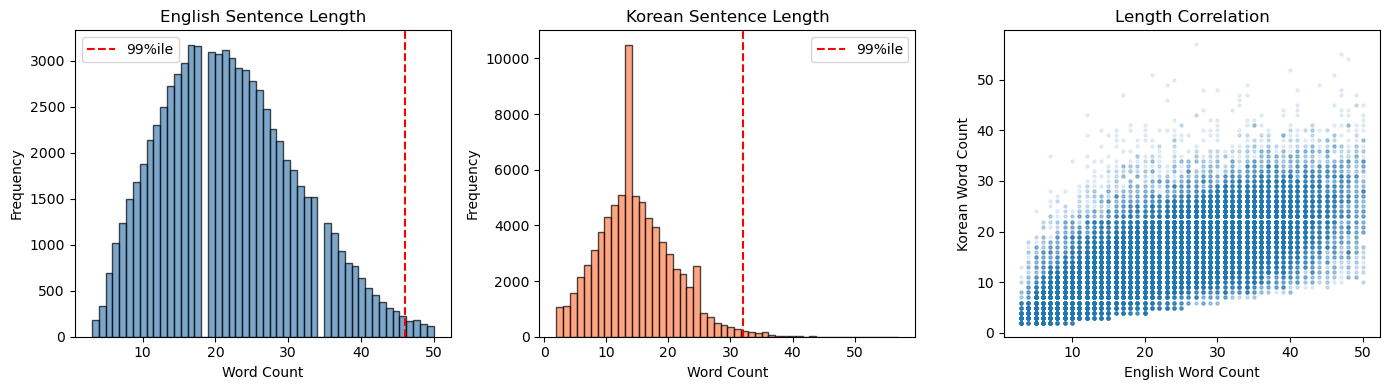


EDA 요약
  원본: 94,123 -> 최종: 77,448 문장 쌍
  제거: 16,675개 (17.7%)

데이터 분할 완료
  Train: 61,958
  Val:   7,745
  Test:  7,745


In [83]:
# =============================================================================
# 2.5 탐색적 데이터 분석 (EDA) + 데이터 분할
# =============================================================================

def perform_eda(eng_sentences: List[str], kor_sentences: List[str], 
                min_eng_words: int = 3, max_eng_words: int = 50,
                min_kor_words: int = 2, max_kor_words: int = 60) -> pd.DataFrame:
    """
    영어-한국어 병렬 코퍼스에 대한 탐색적 데이터 분석을 수행합니다.
    """
    print("=" * 60)
    print("탐색적 데이터 분석 (EDA)")
    print("=" * 60)

    # 전처리 적용
    print("\n전처리 중...")
    eng_processed = [preprocess_sentence(s, 'eng') for s in tqdm(eng_sentences, desc="영어")]
    kor_processed = [preprocess_sentence(s, 'kor') for s in tqdm(kor_sentences, desc="한국어")]

    df = pd.DataFrame({'eng': eng_processed, 'kor': kor_processed})
    print(f"\n원본 데이터: {len(df):,} 문장 쌍")

    # 1. 중복 제거
    print(f"\n" + "-" * 40)
    print("1. 중복 분석")
    print("-" * 40)
    num_duplicates = df.duplicated().sum()
    print(f"중복된 문장 쌍: {num_duplicates:,}")
    if num_duplicates > 0:
        df = df.drop_duplicates().reset_index(drop=True)
        print(f"중복 제거 후: {len(df):,} 문장 쌍")

    # 2. 결측치 확인
    print(f"\n" + "-" * 40)
    print("2. 결측치 분석")
    print("-" * 40)
    missing = (df['eng'] == '').sum() + (df['kor'] == '').sum() + df.isna().sum().sum()
    if missing > 0:
        df = df[(df['eng'] != '') & (df['kor'] != '')].dropna().reset_index(drop=True)
        print(f"결측치 제거: {missing:,}개")
    else:
        print("결측치 없음")

    # 3. 길이 필터링
    print(f"\n" + "-" * 40)
    print("3. 길이 필터링")
    print("-" * 40)
    df['eng_len'] = df['eng'].apply(lambda x: len(x.split()))
    df['kor_len'] = df['kor'].apply(lambda x: len(x.split()))
    before_filter = len(df)
    df = df[(df['eng_len'] >= min_eng_words) & (df['eng_len'] <= max_eng_words) &
            (df['kor_len'] >= min_kor_words) & (df['kor_len'] <= max_kor_words)].reset_index(drop=True)
    print(f"기준: 영어 {min_eng_words}-{max_eng_words} 단어, 한국어 {min_kor_words}-{max_kor_words} 단어")
    print(f"필터링 후: {len(df):,} 문장 쌍 (제거: {before_filter - len(df):,})")

    # 4. 이상치 제거
    print(f"\n" + "-" * 40)
    print("4. 이상치 탐지 (길이 비율)")
    print("-" * 40)
    df['ratio'] = df['eng_len'] / df['kor_len'].replace(0, np.nan)
    outlier_mask = (df['ratio'] > 5) | (df['ratio'] < 0.2) | (df['ratio'].isna())
    num_outliers = outlier_mask.sum()
    if num_outliers > 0:
        print(f"이상치: {num_outliers:,}개 (비율 > 5 또는 < 0.2)")
        df = df[~outlier_mask].reset_index(drop=True)
        print(f"이상치 제거 후: {len(df):,} 문장 쌍")
    else:
        print("이상치 없음")

    # 5. 통계
    print(f"\n" + "-" * 40)
    print("5. 최종 데이터 통계")
    print("-" * 40)
    for lang, col in [('영어', 'eng_len'), ('한국어', 'kor_len')]:
        stats = df[col].describe(percentiles=[0.5, 0.95, 0.99])
        print(f"{lang}: 평균={stats['mean']:.1f}, 중앙값={stats['50%']:.1f}, 99%ile={stats['99%']:.1f}, 최대={stats['max']:.0f}")

    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    axes[0].hist(df['eng_len'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(df['eng_len'].quantile(0.99), color='red', linestyle='--', label='99%ile')
    axes[0].set_xlabel('Word Count'); axes[0].set_ylabel('Frequency')
    axes[0].set_title('English Sentence Length'); axes[0].legend()

    axes[1].hist(df['kor_len'], bins=50, color='coral', alpha=0.7, edgecolor='black')
    axes[1].axvline(df['kor_len'].quantile(0.99), color='red', linestyle='--', label='99%ile')
    axes[1].set_xlabel('Word Count'); axes[1].set_ylabel('Frequency')
    axes[1].set_title('Korean Sentence Length'); axes[1].legend()

    axes[2].scatter(df['eng_len'], df['kor_len'], alpha=0.1, s=5)
    axes[2].set_xlabel('English Word Count'); axes[2].set_ylabel('Korean Word Count')
    axes[2].set_title('Length Correlation')
    plt.tight_layout(); plt.show()

    print(f"\n" + "=" * 60)
    print("EDA 요약")
    print(f"  원본: {len(eng_sentences):,} -> 최종: {len(df):,} 문장 쌍")
    print(f"  제거: {len(eng_sentences) - len(df):,}개 ({(len(eng_sentences) - len(df)) / len(eng_sentences) * 100:.1f}%)")
    print("=" * 60)
    return df[['eng', 'kor']]


# =============================================================================
# 실행: 데이터 로드 -> EDA -> 분할
# =============================================================================
eng_raw, kor_raw = load_data(ENG_TRAIN_PATH, KOR_TRAIN_PATH)
df_clean = perform_eda(eng_raw, kor_raw)

# 정제된 데이터로 분할
questions = df_clean['kor'].tolist()
answers = df_clean['eng'].tolist()

train_q, temp_q, train_a, temp_a = train_test_split(
    questions, answers, train_size=DATA_CONFIG.train_ratio, random_state=SEED
)
val_q, test_q, val_a, test_a = train_test_split(
    temp_q, temp_a, test_size=0.5, random_state=SEED
)

print(f"\n데이터 분할 완료")
print(f"  Train: {len(train_q):,}")
print(f"  Val:   {len(val_q):,}")
print(f"  Test:  {len(test_q):,}")

In [84]:
# # 데이터 로드 및 EDAnalysis 실행
# eng_raw, kor_raw = load_data(ENG_TRAIN_PATH, KOR_TRAIN_PATH)

# # EDA 수행 (중복/이상치 제거 포함)
# df_clean = perform_eda(eng_raw, kor_raw)

# # 정제된 데이터 추출
# eng_sentences = df_clean['eng'].tolist()
# kor_sentences = df_clean['kor'].tolist()

# print(f"\n학습에 사용할 데이터: {len(eng_sentences):,} 문장 쌍")

## 3. 데이터 증강: Back-Translation

**개선사항**: Synonym Replacement 대신 Back-Translation 사용
- 사전 학습된 MarianMT 모델 사용 (빠른 처리)
- 전체 데이터의 일부(10%)만 증강하여 시간 절약
- 번역 품질 유지

In [85]:
def back_translate_augmentation(
    sentences: List[str],
    ratio: float = 0.1,
    batch_size: int = 32,
    use_pretrained: bool = True) -> Tuple[List[str], List[int]]:
    """
    Back-translation을 사용한 데이터 증강

    Args:
        sentences: 증강할 문장 리스트
        ratio: 증강할 비율 (0.1 = 10%)
        batch_size: 배치 크기
        use_pretrained: 사전 학습된 모델 사용 여부

    Returns:
        증강된 문장 리스트
    """
    print("=" * 60)
    print("Back-Translation 데이터 증강 시작")
    print(f"증강 비율: {ratio*100:.1f}%")

    if not use_pretrained:
        print("사전 학습 모델을 비사용")
        print("=" * 60)
        return [], []

    try:
        from transformers import MarianMTModel, MarianTokenizer

        # 경량 모델 사용 (빠른 처리)
        model_name_ko_en = "Helsinki-NLP/opus-mt-ko-en"
        model_name_en_ko = "Helsinki-NLP/opus-mt-en-ko"

        print(f"모델 로드 중: {model_name_en_ko}")
        tokenizer_en_ko = MarianTokenizer.from_pretrained(model_name_en_ko)
        model_en_ko = MarianMTModel.from_pretrained(model_name_en_ko).to(device)
        model_en_ko.eval()

        print(f"모델 로드 중: {model_name_ko_en}")
        tokenizer_ko_en = MarianTokenizer.from_pretrained(model_name_ko_en)
        model_ko_en = MarianMTModel.from_pretrained(model_name_ko_en).to(device)
        model_ko_en.eval()

    except Exception as e:
        print(f"MarianMT 모델 로드 실패: {e}")
        print("transformers 라이브러리 설치 필요: pip install transformers")
        print("원본 데이터를 그대로 반환합니다.")
        print("=" * 60)
        return [], []

    # 증강할 문장 샘플링
    num_to_augment = int(len(sentences) * ratio)
    indices_to_augment = random.sample(range(len(sentences)), min(num_to_augment, len(sentences)))

    augmented_sentences = []

    print(f"증강 대상 문장 수: {len(indices_to_augment):,}")

    with torch.no_grad():
        for i in tqdm(range(0, len(indices_to_augment), batch_size), desc="Back-Translation"):
            batch_indices = indices_to_augment[i:i+batch_size]
            batch_sentences = [sentences[idx] for idx in batch_indices]

            try:
                # 1. korean -> enlgish
                inputs = tokenizer_ko_en(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=50)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                translated_en = model_ko_en.generate(**inputs, max_length=50, num_beams=1)
                english_texts = tokenizer_ko_en.batch_decode(translated_en, skip_special_tokens=True)

                # 2. english -> korean (back-translation)
                inputs = tokenizer_en_ko(english_texts, return_tensors="pt", padding=True, truncation=True, max_length=50)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                translated_ko = model_en_ko.generate(**inputs, max_length=50, num_beams=1)
                back_translated = tokenizer_en_ko.batch_decode(translated_ko, skip_special_tokens=True)

                augmented_sentences.extend(back_translated)

            except Exception as e:
                print(f"배치 처리 중 오류 발생: {e}")
                continue

    print(f"증강 완료: {len(augmented_sentences):,}개 문장 생성")
    print("=" * 60)

    return augmented_sentences, indices_to_augment


def augment_train_data_bt(
    train_q: List[str],
    train_a: List[str],
    bt_ratio: float = 0.1
) -> Tuple[List[str], List[str]]:
    """
    Back-translation을 사용하여 학습 데이터를 증강합니다.

    Args:
        train_q: 영어 질문 리스트
        train_a: 한국어 답변 리스트
        bt_ratio: Back-translation 증강 비율

    Returns:
        증강된 (질문, 답변) 튜플
    """
    print("=" * 60)
    print("Back-Translation 데이터 증강")

    # Back-translated 영어 문장 생성
    bt_questions, used_indices = back_translate_augmentation(train_q, ratio=bt_ratio)


    if len(bt_questions) == 0:
        print("증강된 데이터가 없습니다. 원본 데이터를 그대로 사용합니다.")
        print("=" * 60)
        return train_q, train_a

    # 증강 데이터 추가
    aug_q = train_q + bt_questions
    # Back-translation된 영어에 대응하는 한국어는 원본에서 샘플링
    aug_a = train_a + [train_a[i] for i in used_indices]  # 같은 인덱스!


    print(f"증강 전 Train 개수: {len(train_q):,}")
    print(f"증강 후 Train 개수: {len(aug_q):,}")
    print(f"증강 비율: {len(aug_q) / len(train_q):.2f}x")
    print("데이터 증강 완료!")
    print("=" * 60)

    return aug_q, aug_a

## 4. Tokenizer 학습 (SentencePiece)

**개선사항**: Train data만 사용하여 tokenizer 학습 (Data Leakage 방지)

In [86]:
def train_sentencepiece(data: List[str], model_prefix: str, vocab_size: int = 8000):
    """
    SentencePiece 모델을 학습합니다.

    Train data만 사용 (Val/Test 데이터 제외)
    """
    print("=" * 60)
    print(f"SentencePiece 학습: {model_prefix} (Vocab: {vocab_size})")

    corpus_path = f'{model_prefix}_corpus.txt'
    with open(corpus_path, 'w', encoding='utf-8') as f:
        for line in data:
            f.write(line + '\n')

    # SentencePiece 학습
    spm.SentencePieceTrainer.train(
        input=corpus_path,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        character_coverage=0.9995,
        model_type='bpe',
        byte_fallback=True,
        split_digits=True,

        pad_id=0,
        unk_id=1,
        bos_id=2,
        eos_id=3,
        pad_piece='<pad>',
        unk_piece='<unk>',
        bos_piece='<s>',
        eos_piece='</s>',
        user_defined_symbols=[],
    )

    # 임시 파일 삭제
    if os.path.exists(corpus_path):
        os.remove(corpus_path)

    print(f"SentencePiece 학습 완료: {model_prefix}.model")
    print("=" * 60)


class SPTokenizer:
    """
    SentencePiece Tokenizer Wrapper
    """
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(model_path)

        # 특수 토큰 ID
        self.PAD_ID = 0
        self.UNK_ID = 1
        self.BOS_ID = 2
        self.EOS_ID = 3

        self.vocab_size = self.sp.vocab_size()

    def encode(self, text: str) -> List[int]:
        """텍스트를 토큰 ID로 변환"""
        return self.sp.encode(text, out_type=int)

    def decode(self, ids: List[int]) -> str:
        """토큰 ID를 텍스트로 변환"""
        filtered_ids = [i for i in ids if i not in [self.PAD_ID, self.BOS_ID, self.EOS_ID]]
        return self.sp.decode(filtered_ids)

    def __len__(self):
        return self.vocab_size
print('OVER!')

OVER!


## 5. Dataset 클래스

**개선사항**: BOS/EOS 토큰 처리 로직 수정

In [87]:
class TranslationDataset(Dataset):
    """
    번역 작업을 위한 PyTorch Dataset
    """

    def __init__(self,
                 src_data: List[str],
                 tgt_data: List[str],
                 vocab_src: SPTokenizer,
                 vocab_tgt: SPTokenizer,
                 max_length_src: int = 70,
                 max_length_tgt: int = 80):
        self.src_data = src_data
        self.tgt_data = tgt_data
        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt
        self.max_length_src = max_length_src
        self.max_length_tgt = max_length_tgt

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src_text = self.src_data[idx]
        tgt_text = self.tgt_data[idx]

        # 개선: 먼저 자르고 나서 BOS/EOS 추가 (EOS가 잘리는 것 방지)
        src_encoded = self.vocab_src.encode(src_text)
        tgt_encoded = self.vocab_tgt.encode(tgt_text)

        # 각각 다른 max_length 적용
        src_encoded = src_encoded[:self.max_length_src - 2]
        tgt_encoded = tgt_encoded[:self.max_length_tgt - 2]

        # BOS, EOS 추가
        src_encoded = [self.vocab_src.BOS_ID] + src_encoded + [self.vocab_src.EOS_ID]
        tgt_encoded = [self.vocab_tgt.BOS_ID] + tgt_encoded + [self.vocab_tgt.EOS_ID]

        return {
            'src': torch.tensor(src_encoded, dtype=torch.long),
            'tgt': torch.tensor(tgt_encoded, dtype=torch.long)
        }


def collate_fn(batch):
    """
    배치 내 시퀀스들을 패딩하여 같은 길이로 만듭니다.
    """
    src_batch = [item['src'] for item in batch]
    tgt_batch = [item['tgt'] for item in batch]

    # 패딩 (PAD_ID=0)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=0)

    return {
        'src': src_padded,
        'tgt': tgt_padded
    }

## 6. Transformer 모델 정의

In [88]:
class MultiHeadAttention(nn.Module):
    """멀티 헤드 어텐션"""

    def __init__(self, emb_dim, num_heads, dropout=0.0, bias=False,
                 encoder_decoder_attention=False, causal=False):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads

        assert self.head_dim * num_heads == self.emb_dim

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal

        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.head_dim)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, attention_mask=None):
        q = self.q_proj(query)

        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_weights = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            if self.causal:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(0).unsqueeze(1), float("-inf")
                )
            else:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(1).unsqueeze(2), float("-inf")
                )

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, v)

        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class PositionWiseFeedForward(nn.Module):
    """위치별 피드포워드 네트워크"""

    def __init__(self, emb_dim, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x


class SinusoidalPositionalEmbedding(nn.Embedding):
    """사인/코사인 위치 임베딩"""

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim)
        # self._init_weight(self.weight)
        self.weight = self._init_weight(self.weight)

    # @staticmethod
    # def _init_weight(out):
    #     n_pos, embed_dim = out.shape
    #     position_enc = torch.zeros(n_pos, embed_dim)

    #     for pos in range(n_pos):
    #         for i in range(0, embed_dim, 2):
    #             position_enc[pos, i] = math.sin(pos / (10000 ** (i / embed_dim)))
    #             if i + 1 < embed_dim:
    #                 position_enc[pos, i + 1] = math.cos(pos / (10000 ** ((i + 1) / embed_dim)))

    #     out.data.copy_(position_enc)
    #     out.requires_grad = False
    @staticmethod
    def _init_weight(out: nn.Parameter):
        n_pos, embed_dim = out.shape
        pe = torch.zeros(n_pos, embed_dim)
        
        position = torch.arange(0, n_pos, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)  # 같은 div_term!
        
        return nn.Parameter(pe, requires_grad=False)

    @torch.no_grad()
    def forward(self, input_ids):
        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
        return super().forward(positions)


In [89]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.dropout)
        self.ffn = PositionWiseFeedForward(config.emb_dim, config.ffn_dim, config.dropout)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.dropout = config.dropout

    def forward(self, x, attention_mask=None):
        norm_x = self.norm1(x)
        attn_output, attn_weights = self.self_attn(norm_x, norm_x, attention_mask)
        x = x + F.dropout(attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm2(x)
        ffn_output = self.ffn(norm_x)
        x = x + F.dropout(ffn_output, p=self.dropout, training=self.training)

        return x, attn_weights


class Encoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()
        self.config=config
        self.padding_idx = embed_tokens.padding_idx
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_length + 10, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.num_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.final_norm = nn.LayerNorm(config.emb_dim)

    def forward(self, input_ids, attention_mask=None):
        inputs_embeds = self.embed_tokens(input_ids) * math.sqrt(self.config.emb_dim)
        embed_pos = self.embed_positions(input_ids)
        x = self.dropout(inputs_embeds + embed_pos)

        attention_scores = []
        for layer in self.layers:
            x, attn = layer(x, attention_mask)
            attention_scores.append(attn)

        x = self.final_norm(x)
        return x, attention_scores


class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.dropout, causal=True)
        self.cross_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.dropout, encoder_decoder_attention=True)
        self.ffn = PositionWiseFeedForward(config.emb_dim, config.ffn_dim, config.dropout)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.norm3 = nn.LayerNorm(config.emb_dim)
        self.dropout = config.dropout

    def forward(self, x, encoder_output, encoder_attention_mask=None, decoder_causal_mask=None):
        norm_x = self.norm1(x)
        self_attn_output, self_attn_weights = self.self_attn(norm_x, norm_x, decoder_causal_mask)
        x = x + F.dropout(self_attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm2(x)
        cross_attn_output, cross_attn_weights = self.cross_attn(norm_x, encoder_output, encoder_attention_mask)
        x = x + F.dropout(cross_attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm3(x)
        ffn_output = self.ffn(norm_x)
        x = x + F.dropout(ffn_output, p=self.dropout, training=self.training)

        return x, (self_attn_weights, cross_attn_weights)


class Decoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()
        self.config = config
        self.padding_idx = embed_tokens.padding_idx
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_length + 10, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.num_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.final_norm = nn.LayerNorm(config.emb_dim)

    def forward(self, input_ids, encoder_output, encoder_attention_mask=None, decoder_causal_mask=None):
        inputs_embeds = self.embed_tokens(input_ids) * math.sqrt(self.config.emb_dim)
        embed_pos = self.embed_positions(input_ids)
        x = self.dropout(inputs_embeds + embed_pos)

        attention_scores = []
        for layer in self.layers:
            x, attn = layer(x, encoder_output, encoder_attention_mask, decoder_causal_mask)
            attention_scores.append(attn)

        x = self.final_norm(x)
        return x, attention_scores



In [90]:
class Transformer(nn.Module):
    """Transformer 모델"""

    def __init__(self, vocab_src, vocab_tgt, config):
        super().__init__()
        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt
        self.config = config

        #embedding here; this nn.Embedding automatically has requires_grad=True by default
        self.enc_embedding = nn.Embedding(len(vocab_src), config.emb_dim, padding_idx=vocab_src.PAD_ID)
        self.dec_embedding = nn.Embedding(len(vocab_tgt), config.emb_dim, padding_idx=vocab_tgt.PAD_ID)

        self.encoder = Encoder(config, self.enc_embedding)
        self.decoder = Decoder(config, self.dec_embedding)
        self.prediction_head = nn.Linear(config.emb_dim, len(vocab_tgt), bias=False)
        self.prediction_head.weight = self.dec_embedding.weight

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_mask(self, src, tgt):
        enc_attention_mask = (src == self.vocab_src.PAD_ID)
        tgt_len = tgt.size(1)
        dec_causal_mask = torch.triu(
            torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=tgt.device), diagonal=1
        )
        return enc_attention_mask, dec_causal_mask

    def forward(self, src, tgt):
        enc_attention_mask, dec_causal_mask = self.generate_mask(src, tgt)
        encoder_output, encoder_attn = self.encoder(src, enc_attention_mask)
        decoder_output, decoder_attn = self.decoder(tgt, encoder_output, enc_attention_mask, dec_causal_mask)
        logits = self.prediction_head(decoder_output)
        return logits, encoder_attn, decoder_attn

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class LabelSmoothingLoss(nn.Module):
    """Label Smoothing을 적용한 Cross Entropy Loss"""

    def __init__(self, classes, smoothing=0.1, dim=-1, ignore_index=None):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)

            if self.ignore_index is not None:
                true_dist[:, self.ignore_index] = 0
                mask = torch.nonzero(target.data == self.ignore_index)
                if mask.dim() > 0:
                    true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

## 7. 학습 설정 (Optimizer, Scheduler)

In [91]:
class WarmupScheduler:
    """Transformer 논문의 Learning Rate Schedule"""

    def __init__(self, optimizer, d_model, warmup_steps):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def step(self):
        self.current_step += 1
        lr = self._get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def _get_lr(self):
        step = self.current_step
        return (self.d_model ** -0.5) * min(step ** -0.5, step * (self.warmup_steps ** -1.5))

## 8. BLEU Score 평가 함수

**개선사항**: 번역 품질 평가를 위한 BLEU Score 추가

In [92]:
def calculate_bleu(references, hypotheses):
    """
    BLEU Score 계산

    Args:
        references: 정답 문장 리스트 (List[List[str]])
        hypotheses: 예측 문장 리스트 (List[str])

    Returns:
        BLEU Score (0-100)
    """
    if USE_SACREBLEU:
        bleu = sacrebleu.corpus_bleu(hypotheses, [references], tokenize='intl')
        return bleu.score
    else:
        from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
        smoothing = SmoothingFunction().method1

        #문자 단위로 토큰화 (띄어쓰기 무시)
        formatted_refs = [[list(ref.replace(' ', ''))] for ref in references]
        formatted_hyps = [list(hyp.replace(' ', '')) for hyp in hypotheses]

        score = corpus_bleu(formatted_refs, formatted_hyps, smoothing_function=smoothing)
        return score * 100


def greedy_decode(model, src, vocab_src, vocab_tgt, device, max_length=50, return_attention=False):
    """
    Greedy Decoding (기본 방식)
    """
    model.eval()

    with torch.no_grad():
        src = src.to(device)
        enc_attention_mask = (src == vocab_src.PAD_ID)
        encoder_output, _ = model.encoder(src, enc_attention_mask)

        # 시작 토큰
        tgt = torch.tensor([[vocab_tgt.BOS_ID]], dtype=torch.long, device=device)
        all_cross_attentions = []

        for _ in range(max_length):
            tgt_len = tgt.size(1)
            dec_causal_mask = torch.triu(
                torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=device), diagonal=1
            )

            decoder_output, decoder_attn = model.decoder(tgt, encoder_output, enc_attention_mask, dec_causal_mask)
            logits = model.prediction_head(decoder_output)

            next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
            tgt = torch.cat([tgt, next_token], dim=1)
            
            if return_attention:
                # decoder_attn[-1] = (self_attn, cross_attn)
                cross_attn = decoder_attn[-1][1]  # [batch, heads, tgt_len, src_len]
                all_cross_attentions.append(cross_attn[:, :, -1:, :])  # 마지막 토큰의 attention만

            if next_token.item() == vocab_tgt.EOS_ID:
                break
        if return_attention:
            # [batch, heads, tgt_len, src_len] -> [heads, tgt_len, src_len]
            attention = torch.cat(all_cross_attentions, dim=2).squeeze(0)
            return tgt, attention

        return tgt

## 9. Beam Search

**개선사항**: Greedy Decoding 대신 Beam Search 사용

In [93]:
def beam_search_decode(model, src, vocab_src, vocab_tgt, device, beam_size=5, max_length=50, alpha=0.6):
    """
    Beam Search Decoding

    Args:
        model: Transformer 모델
        src: 입력 시퀀스 (batch_size=1)
        vocab_src: 소스 vocabulary
        vocab_tgt: 타겟 vocabulary
        device: 디바이스
        beam_size: Beam 크기
        max_length: 최대 생성 길이
        alpha: Length penalty (0.6-0.7 권장)

    Returns:
        최적 시퀀스
    """
    model.eval()

    with torch.no_grad():
        src = src.to(device)
        enc_attention_mask = (src == vocab_src.PAD_ID)
        encoder_output, _ = model.encoder(src, enc_attention_mask)

        # 시작: (시퀀스, 점수)
        sequences = [([vocab_tgt.BOS_ID], 0.0)]

        for step in range(max_length):
            all_candidates = []

            for seq, score in sequences:
                # EOS에 도달했으면 스킵
                if seq[-1] == vocab_tgt.EOS_ID:
                    all_candidates.append((seq, score))
                    continue

                tgt = torch.tensor([seq], dtype=torch.long, device=device)
                tgt_len = tgt.size(1)
                dec_causal_mask = torch.triu(
                    torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=device), diagonal=1
                )

                decoder_output, _ = model.decoder(tgt, encoder_output, enc_attention_mask, dec_causal_mask)
                logits = model.prediction_head(decoder_output)
                log_probs = F.log_softmax(logits[:, -1, :], dim=-1)

                # Top-k 선택
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_size)

                for log_prob, idx in zip(topk_log_probs[0], topk_indices[0]):
                    candidate = (seq + [idx.item()], score + log_prob.item())
                    all_candidates.append(candidate)

            # Length penalty 적용하여 정렬
            ordered = sorted(all_candidates, key=lambda x: x[1] / (len(x[0]) ** alpha), reverse=True)
            sequences = ordered[:beam_size]

            # 모든 시퀀스가 EOS에 도달했으면 종료
            if all(seq[-1] == vocab_tgt.EOS_ID for seq, _ in sequences):
                break

        # 최고 점수 시퀀스 반환
        best_seq = sequences[0][0]
        return torch.tensor([best_seq], dtype=torch.long, device=device)


def translate_sentence(sentence, model, vocab_src, vocab_tgt, device, use_beam_search=True, beam_size=5, return_attention=False):
    """
    문장을 번역합니다.

    Args:
        sentence: 번역할 문장 (str)
        model: Transformer 모델
        vocab_src: 소스 vocabulary
        vocab_tgt: 타겟 vocabulary
        device: 디바이스
        use_beam_search: Beam Search 사용 여부
        beam_size: Beam 크기

    Returns:
        번역된 문장 (str)
    """
    model.eval()

    # 문장 전처리 및 인코딩
    sentence = preprocess_sentence(sentence, 'kor')
    src_encoded = [vocab_src.BOS_ID] + vocab_src.encode(sentence) + [vocab_src.EOS_ID]
    src = torch.tensor([src_encoded], dtype=torch.long)

    if return_attention:
        # Attention 시각화는 greedy만 지원 (beam search는 복잡함)
        tgt, attention = greedy_decode(model, src, vocab_src, vocab_tgt, device, return_attention=True)
        tgt_tokens = tgt[0].cpu().tolist()
        translation = vocab_tgt.decode(tgt_tokens)
        return translation, attention.cpu(), src_encoded, tgt_tokens

    # 번역
    if use_beam_search:
        tgt = beam_search_decode(model, src, vocab_src, vocab_tgt, device, beam_size=beam_size)
    else:
        tgt = greedy_decode(model, src, vocab_src, vocab_tgt, device)

    # 디코딩
    tgt_tokens = tgt[0].cpu().tolist()
    translation = vocab_tgt.decode(tgt_tokens)

    return translation

## 10. 학습 및 평가 함수

**개선사항**: BLEU Score 추가로 번역 품질 평가

In [94]:
def train_epoch(model, iterator, optimizer, criterion, clip, device, scheduler=None):
    """한 에폭 동안 모델을 학습합니다."""
    model.train()
    epoch_loss = 0

    for batch in tqdm(iterator, desc="  Training"):
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        optimizer.zero_grad()
        output, _, _ = model(src, tgt[:, :-1])

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion, device):
    """모델을 평가합니다."""
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output, _, _ = model(src, tgt[:, :-1])

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)

            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate_bleu(model, data_loader, vocab_src, vocab_tgt, device, num_samples=100, use_beam_search=True):
    """
    BLEU Score를 계산합니다.

    Args:
        model: Transformer 모델
        data_loader: 평가용 데이터 로더
        vocab_src: 소스 vocabulary
        vocab_tgt: 타겟 vocabulary
        device: 디바이스
        num_samples: 평가할 샘플 수
        use_beam_search: Beam Search 사용 여부

    Returns:
        BLEU Score
    """
    model.eval()
    references = []
    hypotheses = []

    count = 0
    for batch in data_loader:
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        batch_size = src.size(0)
        for i in range(batch_size):
            if count >= num_samples:
                break

            src_seq = src[i:i+1]
            tgt_seq = tgt[i]

            # 번역
            if use_beam_search:
                pred_seq = beam_search_decode(model, src_seq, vocab_src, vocab_tgt, device, beam_size=5)
            else:
                pred_seq = greedy_decode(model, src_seq, vocab_src, vocab_tgt, device)

            # 디코딩
            pred_tokens = pred_seq[0].cpu().tolist()
            tgt_tokens = tgt_seq.cpu().tolist()

            pred_text = vocab_tgt.decode(pred_tokens)
            tgt_text = vocab_tgt.decode(tgt_tokens)

            references.append(tgt_text)
            hypotheses.append(pred_text)

            count += 1

        if count >= num_samples:
            break

    bleu_score = calculate_bleu(references, hypotheses)
    return bleu_score

## 11. 데이터 로드 및 전처리 실행

In [95]:
# # 데이터 로드
# print("=" * 60)
# print("데이터 로드")
# questions, answers = load_data(ENG_TRAIN_PATH, KOR_TRAIN_PATH)

# # 전처리
# questions, answers = preprocess_data(questions, answers)

# # 데이터 분할 (Train 80%, Val 10%, Test 10%)
# train_q, temp_q, train_a, temp_a = train_test_split(
#     questions, answers,
#     train_size=DATA_CONFIG.train_ratio,
#     random_state=SEED
# )

# val_q, test_q, val_a, test_a = train_test_split(
#     temp_q, temp_a,
#     test_size=0.5,  # 나머지의 50%씩
#     random_state=SEED
# )

# print("=" * 60)
# print("데이터 분할 완료")
# print(f"Train: {len(train_q):,}")
# print(f"Val:   {len(val_q):,}")
# print(f"Test:  {len(test_q):,}")
# print("=" * 60)


### Back-Translation 데이터 증강 (선택적)

⚠️  이 셀은 시간이 오래 걸립니다 (10-30분).
transformers 라이브러리가 설치되어 있어야 합니다: `pip install transformers`

빠르게 테스트하고 싶다면 이 셀을 건너뛰세요 (원본 데이터만 사용).

In [96]:
# Back-translation 수행 (시간 절약을 위해 선택적)
USE_BACK_TRANSLATION = False  # True로 변경하면 Back-translation 수행

if USE_BACK_TRANSLATION:
    train_q, train_a = augment_train_data_bt(
        train_q, train_a,
        bt_ratio=DATA_CONFIG.bt_ratio
    )
else:
    print("Back-translation 생략")
    print("원본 데이터만 사용")

Back-translation 생략
원본 데이터만 사용


## 12. Tokenizer 학습

**개선사항**: Train data만 사용 (Data Leakage 방지)

In [97]:
# Tokenizer 학습 (또는 로드)
eng_model_path = f"{ENG_TOKENIZER_PREFIX}.model"
kor_model_path = f"{KOR_TOKENIZER_PREFIX}.model"

#Train data만 사용
if not os.path.exists(kor_model_path):
    print("korean Tokenizer 학습 중...")
    train_sentencepiece(train_q, KOR_TOKENIZER_PREFIX, DATA_CONFIG.vocab_size_kor)
else:
    print(f"korean Tokenizer 로드: {kor_model_path}")

if not os.path.exists(eng_model_path):
    print("eng Tokenizer 학습 중...")
    train_sentencepiece(train_a, ENG_TOKENIZER_PREFIX, DATA_CONFIG.vocab_size_eng)
else:
    print(f"eng Tokenizer 로드: {eng_model_path}")

# Tokenizer 로드
vocab_eng = SPTokenizer(eng_model_path)
vocab_kor = SPTokenizer(kor_model_path)

print("=" * 60)
print(f"영어 Vocab 크기: {len(vocab_eng):,}")
print(f"한국어 Vocab 크기: {len(vocab_kor):,}")
print("=" * 60)

# 샘플 테스트
sample_eng = train_a[0]
sample_kor = train_q[0]
print(f"\n샘플 영어: {sample_eng}")
print(f"인코딩: {vocab_eng.encode(sample_eng)[:20]}")
print(f"\n샘플 한국어: {sample_kor}")
print(f"인코딩: {vocab_kor.encode(sample_kor)[:20]}")


korean Tokenizer 로드: ./tokenizers/sp_kor.model
eng Tokenizer 로드: ./tokenizers/sp_eng.model
영어 Vocab 크기: 16,000
한국어 Vocab 크기: 16,000

샘플 영어: new york (cnn) the consumer product safety commission, in cooperation with mattel inc., announced late tuesday that it is recalling about 700,000 chinese-made toys that have excessive amounts of lead paint.
인코딩: [454, 1233, 493, 802, 15987, 265, 3675, 3815, 2844, 1985, 15968, 284, 4431, 361, 10878, 526, 2438, 1342, 1563, 754]

샘플 한국어: 미국 유명 완구업체 마텔사와 협력하고 있는 소비자상품안전위원회는 4일(현지시간) 납성분의 페인트가 함유된 약 70만개의 중국 산 장난감을 리콜조치할 것이라 밝혔다.
인코딩: [313, 1404, 934, 14762, 1098, 13218, 1853, 2337, 288, 319, 4207, 14732, 15045, 5249, 3210, 14683, 14817, 14719, 14755, 379]


## 13. DataLoader 생성

In [98]:
print("=" * 60)
print("DataLoader 생성")

# Dataset 생성
train_dataset = TranslationDataset(train_q, train_a, vocab_kor, vocab_eng, max_length_src=DATA_CONFIG.max_length_src, max_length_tgt=DATA_CONFIG.max_length_tgt)
val_dataset = TranslationDataset(val_q, val_a, vocab_kor, vocab_eng, max_length_src=DATA_CONFIG.max_length_src,max_length_tgt=DATA_CONFIG.max_length_tgt)
test_dataset = TranslationDataset(test_q, test_a, vocab_kor, vocab_eng, max_length_src=DATA_CONFIG.max_length_src, max_length_tgt=DATA_CONFIG.max_length_tgt)
# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=DATA_CONFIG.num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=DATA_CONFIG.num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=DATA_CONFIG.batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=DATA_CONFIG.num_workers
)

print(f"Train Batches: {len(train_loader):,}")
print(f"Val Batches:   {len(val_loader):,}")
print(f"Test Batches:  {len(test_loader):,}")
print("=" * 60)

# 샘플 배치 확인
sample_batch = next(iter(train_loader))
print(f"\nSample Batch:")
print(f"  Source shape: {sample_batch['src'].shape}")
print(f"  Target shape: {sample_batch['tgt'].shape}")


DataLoader 생성
Train Batches: 969
Val Batches:   122
Test Batches:  122

Sample Batch:
  Source shape: torch.Size([64, 54])
  Target shape: torch.Size([64, 61])


## 14. 모델 초기화

In [99]:
# 모델 설정 (개선됨)
config = EasyDict({
    'emb_dim': MODEL_CONFIG.emb_dim,
    'ffn_dim': MODEL_CONFIG.ffn_dim,
    'num_heads': MODEL_CONFIG.num_heads,
    'num_layers': MODEL_CONFIG.num_layers,
    'dropout': MODEL_CONFIG.dropout,
    'max_length': MODEL_CONFIG.max_length,
})

# 모델 초기화
model = Transformer(vocab_kor, vocab_eng, config).to(device)

print("=" * 60)
print("모델 초기화 완료")
print(f"총 파라미터 수: {model.count_parameters():,}")
print(f"d_model: {config.emb_dim}")
print(f"num_layers: {config.num_layers}")
print(f"num_heads: {config.num_heads}")
print("=" * 60)

# Loss 함수
criterion = LabelSmoothingLoss(
    classes=len(vocab_eng),
    smoothing=TRAIN_CONFIG.label_smoothing,
    ignore_index=vocab_eng.PAD_ID
)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=TRAIN_CONFIG.learning_rate, betas=(0.9, 0.98), eps=1e-9)

# Scheduler
scheduler = WarmupScheduler(optimizer, config.emb_dim, TRAIN_CONFIG.warmup_steps)

모델 초기화 완료
총 파라미터 수: 15,553,536
d_model: 256
num_layers: 4
num_heads: 4


## 15. 학습 실행

In [100]:
print("=" * 60)
print("학습 시작")
print("=" * 60)

# 학습 히스토리
history = {
    'train_loss': [],
    'val_loss': [],
    'val_bleu': [],
    'val_ppl': []
}

best_val_loss =float('inf')
best_epoch = 0
patience_counter = 0

for epoch in range(TRAIN_CONFIG.num_epochs):
    start_time = time.time()

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion,
                             TRAIN_CONFIG.clip_grad, device, scheduler)

    # Evaluate
    val_loss = evaluate(model, val_loader, criterion, device)

    # BLEU Score 계산 (개선사항!)
    val_bleu = evaluate_bleu(model, val_loader, vocab_kor, vocab_eng, device,
                             num_samples=100, use_beam_search=True)

    # what the f the model is spitting out? U gotta check that
    if epoch % 5 == 0:  # 5 에폭마다 출력 (매번 하면 너무 많음)
        model.eval()
        with torch.no_grad():
            debug_batch = next(iter(val_loader))
            debug_src = debug_batch['src'][:1].to(device)
            debug_tgt = debug_batch['tgt'][0].tolist()

            debug_pred = greedy_decode(model, debug_src, vocab_kor, vocab_eng, device)
            debug_pred_tokens = debug_pred[0].tolist()

            print("\n" + "=" * 50)
            print("[DEBUG] 모델 출력 확인")
            print(f"SRC: {vocab_kor.decode(debug_src[0].tolist())}")
            print(f"TGT: {vocab_eng.decode(debug_tgt)}")
            print(f"PRED tokens: {debug_pred_tokens[:20]}...")  # 처음 20개만
            print(f"PRED: {vocab_eng.decode(debug_pred_tokens)}")
            print("=" * 50 + "\n")

    # Perplexity
    train_ppl = math.exp(min(train_loss, 100))
    val_ppl = math.exp(min(val_loss, 100))

    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_bleu'].append(val_bleu)
    history['val_ppl'].append(val_ppl)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    # 출력
    print(f"\nEpoch: {epoch+1:02}/{TRAIN_CONFIG.num_epochs}")
    print(f"  Time: {int(epoch_mins)}m {int(epoch_secs)}s")
    print(f"  Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:.2f}")
    print(f"  Val Loss:   {val_loss:.3f} | Val PPL:   {val_ppl:.2f}")
    print(f"  Val BLEU:   {val_bleu:.2f}")

    # Best 모델 저장
    if val_loss < best_val_loss - TRAIN_CONFIG.min_delta:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_bleu': val_bleu,
            'config': config
        }, MODEL_SAVE_PATH)
        print(f"Best 모델 저장! (Val loss: {val_loss:.2f})")
    else:
        patience_counter += 1
        print(f"Best val loss: {best_val_loss:.2f} (Epoch {best_epoch}) | Patience: {patience_counter}/{TRAIN_CONFIG.patience}")

    # Early Stopping
    if patience_counter >= TRAIN_CONFIG.patience:
        print(f"\nEarly Stopping! (Patience {TRAIN_CONFIG.patience} 도달)")
        break

print(f"Best Val loss: {best_val_loss:.2f} (Epoch {best_epoch})")

학습 시작


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.40it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 291, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]...
PRED: of the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Epoch: 01/100
  Time: 4m 26s
  Train Loss: 31.241 | Train PPL: 36968096015388.91
  Val Loss:   3.814 | Val PPL:   45.35
  Val BLEU:   0.09
Best 모델 저장! (Val loss: 3.81)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.37it/s]



Epoch: 02/100
  Time: 2m 49s
  Train Loss: 3.900 | Train PPL: 49.40
  Val Loss:   3.472 | Val PPL:   32.19
  Val BLEU:   0.00
Best 모델 저장! (Val loss: 3.47)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 03/100
  Time: 2m 47s
  Train Loss: 3.706 | Train PPL: 40.69
  Val Loss:   3.468 | Val PPL:   32.08
  Val BLEU:   0.00
Best 모델 저장! (Val loss: 3.47)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 04/100
  Time: 3m 12s
  Train Loss: 3.536 | Train PPL: 34.32
  Val Loss:   3.387 | Val PPL:   29.57
  Val BLEU:   0.00
Best 모델 저장! (Val loss: 3.39)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 05/100
  Time: 4m 29s
  Train Loss: 3.400 | Train PPL: 29.96
  Val Loss:   3.365 | Val PPL:   28.94
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.37)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.40it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]...
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Epoch: 06/100
  Time: 4m 29s
  Train Loss: 3.338 | Train PPL: 28.18
  Val Loss:   3.356 | Val PPL:   28.68
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.36)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.37it/s]



Epoch: 07/100
  Time: 4m 30s
  Train Loss: 3.291 | Train PPL: 26.88
  Val Loss:   3.285 | Val PPL:   26.71
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.28)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.37it/s]



Epoch: 08/100
  Time: 4m 29s
  Train Loss: 3.270 | Train PPL: 26.30
  Val Loss:   3.267 | Val PPL:   26.23
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.27)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.39it/s]



Epoch: 09/100
  Time: 4m 27s
  Train Loss: 3.256 | Train PPL: 25.95
  Val Loss:   3.261 | Val PPL:   26.07
  Val BLEU:   0.05
Best 모델 저장! (Val loss: 3.26)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 10/100
  Time: 4m 26s
  Train Loss: 3.244 | Train PPL: 25.64
  Val Loss:   3.236 | Val PPL:   25.43
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.24)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]...
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Epoch: 11/100
  Time: 4m 25s
  Train Loss: 3.225 | Train PPL: 25.15
  Val Loss:   3.214 | Val PPL:   24.88
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.21)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



Epoch: 12/100
  Time: 4m 25s
  Train Loss: 3.209 | Train PPL: 24.75
  Val Loss:   3.206 | Val PPL:   24.68
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.21)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.49it/s]



Epoch: 13/100
  Time: 4m 25s
  Train Loss: 3.206 | Train PPL: 24.67
  Val Loss:   3.186 | Val PPL:   24.20
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.19)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.50it/s]



Epoch: 14/100
  Time: 4m 25s
  Train Loss: 3.193 | Train PPL: 24.36
  Val Loss:   3.183 | Val PPL:   24.12
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.18)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 15/100
  Time: 4m 26s
  Train Loss: 3.176 | Train PPL: 23.96
  Val Loss:   3.174 | Val PPL:   23.89
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.17)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.48it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]...
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Epoch: 16/100
  Time: 4m 26s
  Train Loss: 3.167 | Train PPL: 23.74
  Val Loss:   3.156 | Val PPL:   23.48
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.16)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.48it/s]



Epoch: 17/100
  Time: 4m 25s
  Train Loss: 3.161 | Train PPL: 23.60
  Val Loss:   3.145 | Val PPL:   23.23
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.15)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 18/100
  Time: 4m 26s
  Train Loss: 3.148 | Train PPL: 23.28
  Val Loss:   3.137 | Val PPL:   23.04
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.14)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 19/100
  Time: 4m 26s
  Train Loss: 3.141 | Train PPL: 23.12
  Val Loss:   3.129 | Val PPL:   22.86
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.13)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 20/100
  Time: 4m 25s
  Train Loss: 3.133 | Train PPL: 22.94
  Val Loss:   3.126 | Val PPL:   22.79
  Val BLEU:   0.04
Best 모델 저장! (Val loss: 3.13)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]...
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Epoch: 21/100
  Time: 4m 26s
  Train Loss: 3.125 | Train PPL: 22.76
  Val Loss:   3.117 | Val PPL:   22.57
  Val BLEU:   0.03
Best 모델 저장! (Val loss: 3.12)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.49it/s]



Epoch: 22/100
  Time: 4m 26s
  Train Loss: 3.134 | Train PPL: 22.98
  Val Loss:   3.109 | Val PPL:   22.40
  Val BLEU:   0.03
Best 모델 저장! (Val loss: 3.11)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 23/100
  Time: 4m 25s
  Train Loss: 3.117 | Train PPL: 22.58
  Val Loss:   3.105 | Val PPL:   22.32
  Val BLEU:   0.17
Best 모델 저장! (Val loss: 3.11)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



Epoch: 24/100
  Time: 4m 25s
  Train Loss: 3.109 | Train PPL: 22.39
  Val Loss:   3.099 | Val PPL:   22.18
  Val BLEU:   0.05
Best 모델 저장! (Val loss: 3.10)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 25/100
  Time: 4m 23s
  Train Loss: 3.102 | Train PPL: 22.25
  Val Loss:   3.097 | Val PPL:   22.14
  Val BLEU:   0.00
Best 모델 저장! (Val loss: 3.10)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]...
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Epoch: 26/100
  Time: 4m 27s
  Train Loss: 3.107 | Train PPL: 22.35
  Val Loss:   3.089 | Val PPL:   21.97
  Val BLEU:   0.00
Best 모델 저장! (Val loss: 3.09)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 27/100
  Time: 4m 20s
  Train Loss: 3.099 | Train PPL: 22.19
  Val Loss:   3.083 | Val PPL:   21.83
  Val BLEU:   0.05
Best 모델 저장! (Val loss: 3.08)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 28/100
  Time: 4m 26s
  Train Loss: 3.086 | Train PPL: 21.89
  Val Loss:   3.079 | Val PPL:   21.73
  Val BLEU:   0.12
Best 모델 저장! (Val loss: 3.08)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



Epoch: 29/100
  Time: 4m 26s
  Train Loss: 3.080 | Train PPL: 21.76
  Val Loss:   3.070 | Val PPL:   21.53
  Val BLEU:   0.00
Best 모델 저장! (Val loss: 3.07)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



Epoch: 30/100
  Time: 4m 26s
  Train Loss: 3.083 | Train PPL: 21.81
  Val Loss:   3.065 | Val PPL:   21.43
  Val BLEU:   0.00
Best 모델 저장! (Val loss: 3.06)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]...
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Epoch: 31/100
  Time: 4m 21s
  Train Loss: 3.069 | Train PPL: 21.51
  Val Loss:   3.059 | Val PPL:   21.31
  Val BLEU:   0.00
Best 모델 저장! (Val loss: 3.06)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 32/100
  Time: 4m 24s
  Train Loss: 3.070 | Train PPL: 21.54
  Val Loss:   3.054 | Val PPL:   21.21
  Val BLEU:   0.02
Best 모델 저장! (Val loss: 3.05)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.48it/s]



Epoch: 33/100
  Time: 4m 3s
  Train Loss: 3.071 | Train PPL: 21.57
  Val Loss:   3.053 | Val PPL:   21.17
  Val BLEU:   0.17
Best 모델 저장! (Val loss: 3.05)


  Training: 100%|██████████| 969/969 [02:12<00:00,  7.33it/s]



Epoch: 34/100
  Time: 3m 58s
  Train Loss: 3.061 | Train PPL: 21.35
  Val Loss:   3.044 | Val PPL:   20.99
  Val BLEU:   0.03
Best 모델 저장! (Val loss: 3.04)


  Training:  41%|████      | 397/969 [00:55<01:20,  7.09it/s]


Epoch: 35/100
  Time: 4m 14s
  Train Loss: 3.061 | Train PPL: 21.35
  Val Loss:   3.039 | Val PPL:   20.88
  Val BLEU:   0.14
Best 모델 저장! (Val loss: 3.04)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.44it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265]...
PRED: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Epoch: 36/100
  Time: 4m 25s
  Train Loss: 3.054 | Train PPL: 21.20
  Val Loss:   3.034 | Val PPL:   20.78
  Val BLEU:   0.09
Best 모델 저장! (Val loss: 3.03)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.47it/s]



Epoch: 37/100
  Time: 3m 41s
  Train Loss: 3.051 | Train PPL: 21.13
  Val Loss:   3.033 | Val PPL:   20.76
  Val BLEU:   0.42
Best val loss: 3.03 (Epoch 36) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.45it/s]



Epoch: 38/100
  Time: 3m 42s
  Train Loss: 3.036 | Train PPL: 20.83
  Val Loss:   3.026 | Val PPL:   20.61
  Val BLEU:   0.04
Best 모델 저장! (Val loss: 3.03)


  Training:   8%|▊         | 79/969 [00:10<01:54,  7.77it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

  Training: 100%|██████████| 969/969 [02:10<00:00,  7.44it/s]



Epoch: 39/100
  Time: 4m 10s
  Train Loss: 3.041 | Train PPL: 20.93
  Val Loss:   3.018 | Val PPL:   20.46
  Val BLEU:   0.11
Best 모델 저장! (Val loss: 3.02)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 40/100
  Time: 3m 29s
  Train Loss: 3.032 | Train PPL: 20.73
  Val Loss:   3.025 | Val PPL:   20.59
  Val BLEU:   0.33
Best val loss: 3.02 (Epoch 39) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.48it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 15946, 15976, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973]...
PRED: the 100000000000000000000000000000000000000000000000


Epoch: 41/100
  Time: 3m 47s
  Train Loss: 3.044 | Train PPL: 20.98
  Val Loss:   3.024 | Val PPL:   20.57
  Val BLEU:   0.20
Best val loss: 3.02 (Epoch 39) | Patience: 2/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.44it/s]



Epoch: 42/100
  Time: 4m 6s
  Train Loss: 3.035 | Train PPL: 20.79
  Val Loss:   3.012 | Val PPL:   20.33
  Val BLEU:   0.15
Best 모델 저장! (Val loss: 3.01)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.36it/s]



Epoch: 43/100
  Time: 4m 25s
  Train Loss: 3.035 | Train PPL: 20.81
  Val Loss:   3.005 | Val PPL:   20.19
  Val BLEU:   0.12
Best 모델 저장! (Val loss: 3.01)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.42it/s]



Epoch: 44/100
  Time: 4m 21s
  Train Loss: 3.017 | Train PPL: 20.43
  Val Loss:   2.999 | Val PPL:   20.07
  Val BLEU:   0.17
Best 모델 저장! (Val loss: 3.00)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.44it/s]



Epoch: 45/100
  Time: 4m 26s
  Train Loss: 3.015 | Train PPL: 20.39
  Val Loss:   3.012 | Val PPL:   20.32
  Val BLEU:   0.00
Best val loss: 3.00 (Epoch 44) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 15946, 15976, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973]...
PRED: the 100000000000000000000000000000000000000000000000


Epoch: 46/100
  Time: 4m 8s
  Train Loss: 3.014 | Train PPL: 20.36
  Val Loss:   2.995 | Val PPL:   19.98
  Val BLEU:   0.17
Best 모델 저장! (Val loss: 2.99)


  Training: 100%|██████████| 969/969 [02:12<00:00,  7.33it/s]



Epoch: 47/100
  Time: 4m 20s
  Train Loss: 3.003 | Train PPL: 20.15
  Val Loss:   2.993 | Val PPL:   19.94
  Val BLEU:   0.18
Best 모델 저장! (Val loss: 2.99)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.43it/s]



Epoch: 48/100
  Time: 4m 9s
  Train Loss: 3.009 | Train PPL: 20.27
  Val Loss:   2.990 | Val PPL:   19.88
  Val BLEU:   0.06
Best 모델 저장! (Val loss: 2.99)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 49/100
  Time: 4m 21s
  Train Loss: 3.010 | Train PPL: 20.28
  Val Loss:   2.988 | Val PPL:   19.84
  Val BLEU:   0.13
Best 모델 저장! (Val loss: 2.99)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.44it/s]



Epoch: 50/100
  Time: 4m 7s
  Train Loss: 2.998 | Train PPL: 20.04
  Val Loss:   2.984 | Val PPL:   19.76
  Val BLEU:   0.18
Best 모델 저장! (Val loss: 2.98)


  Training: 100%|██████████| 969/969 [02:12<00:00,  7.34it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 15946, 15976, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973]...
PRED: the 100000000000000000000000000000000000000000000000


Epoch: 51/100
  Time: 4m 23s
  Train Loss: 3.005 | Train PPL: 20.19
  Val Loss:   2.984 | Val PPL:   19.76
  Val BLEU:   0.14
Best val loss: 2.98 (Epoch 50) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.45it/s]



Epoch: 52/100
  Time: 4m 21s
  Train Loss: 3.005 | Train PPL: 20.19
  Val Loss:   2.979 | Val PPL:   19.68
  Val BLEU:   0.14
Best 모델 저장! (Val loss: 2.98)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.43it/s]



Epoch: 53/100
  Time: 4m 13s
  Train Loss: 2.993 | Train PPL: 19.94
  Val Loss:   2.978 | Val PPL:   19.65
  Val BLEU:   0.16
Best 모델 저장! (Val loss: 2.98)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.39it/s]



Epoch: 54/100
  Time: 4m 23s
  Train Loss: 2.991 | Train PPL: 19.90
  Val Loss:   2.975 | Val PPL:   19.59
  Val BLEU:   0.18
Best 모델 저장! (Val loss: 2.97)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



Epoch: 55/100
  Time: 4m 12s
  Train Loss: 2.995 | Train PPL: 19.99
  Val Loss:   2.975 | Val PPL:   19.59
  Val BLEU:   0.20
Best val loss: 2.97 (Epoch 54) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.37it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 345, 15950, 15972, 15953, 265, 1990, 15968, 265, 1990, 439, 331, 15967, 3]...
PRED: the "i's the lot, the lot," said.


Epoch: 56/100
  Time: 4m 19s
  Train Loss: 2.989 | Train PPL: 19.87
  Val Loss:   2.969 | Val PPL:   19.47
  Val BLEU:   0.15
Best 모델 저장! (Val loss: 2.97)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.42it/s]



Epoch: 57/100
  Time: 4m 15s
  Train Loss: 2.985 | Train PPL: 19.79
  Val Loss:   2.968 | Val PPL:   19.45
  Val BLEU:   0.15
Best 모델 저장! (Val loss: 2.97)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.40it/s]



Epoch: 58/100
  Time: 3m 59s
  Train Loss: 2.992 | Train PPL: 19.93
  Val Loss:   2.972 | Val PPL:   19.53
  Val BLEU:   0.10
Best val loss: 2.97 (Epoch 57) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 59/100
  Time: 4m 21s
  Train Loss: 2.990 | Train PPL: 19.89
  Val Loss:   2.961 | Val PPL:   19.32
  Val BLEU:   0.12
Best 모델 저장! (Val loss: 2.96)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.42it/s]



Epoch: 60/100
  Time: 4m 8s
  Train Loss: 2.972 | Train PPL: 19.53
  Val Loss:   2.960 | Val PPL:   19.29
  Val BLEU:   0.17
Best 모델 저장! (Val loss: 2.96)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.34it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 15946, 15978, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973]...
PRED: the 200000000000000000000000000000000000000000000000


Epoch: 61/100
  Time: 4m 12s
  Train Loss: 2.980 | Train PPL: 19.68
  Val Loss:   2.956 | Val PPL:   19.23
  Val BLEU:   0.16
Best 모델 저장! (Val loss: 2.96)


  Training: 100%|██████████| 969/969 [02:12<00:00,  7.33it/s]



Epoch: 62/100
  Time: 4m 22s
  Train Loss: 2.972 | Train PPL: 19.52
  Val Loss:   2.957 | Val PPL:   19.23
  Val BLEU:   0.17
Best val loss: 2.96 (Epoch 61) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.41it/s]



Epoch: 63/100
  Time: 4m 21s
  Train Loss: 2.978 | Train PPL: 19.64
  Val Loss:   2.954 | Val PPL:   19.18
  Val BLEU:   0.18
Best 모델 저장! (Val loss: 2.95)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



Epoch: 64/100
  Time: 4m 9s
  Train Loss: 2.976 | Train PPL: 19.61
  Val Loss:   2.950 | Val PPL:   19.11
  Val BLEU:   0.13
Best 모델 저장! (Val loss: 2.95)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.36it/s]



Epoch: 65/100
  Time: 4m 13s
  Train Loss: 2.971 | Train PPL: 19.51
  Val Loss:   2.951 | Val PPL:   19.13
  Val BLEU:   0.11
Best val loss: 2.95 (Epoch 64) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.39it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 563, 15968, 265, 617, 1500, 15968, 265, 15946, 15978, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973, 15973]...
PRED: the government, the first morning, the 20000000000000000000000000000000000000000


Epoch: 66/100
  Time: 3m 53s
  Train Loss: 2.976 | Train PPL: 19.61
  Val Loss:   2.952 | Val PPL:   19.14
  Val BLEU:   0.18
Best val loss: 2.95 (Epoch 64) | Patience: 2/5


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 67/100
  Time: 4m 11s
  Train Loss: 2.965 | Train PPL: 19.40
  Val Loss:   2.945 | Val PPL:   19.01
  Val BLEU:   0.12
Best 모델 저장! (Val loss: 2.94)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.37it/s]



Epoch: 68/100
  Time: 4m 12s
  Train Loss: 2.965 | Train PPL: 19.39
  Val Loss:   2.941 | Val PPL:   18.94
  Val BLEU:   0.39
Best 모델 저장! (Val loss: 2.94)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.37it/s]



Epoch: 69/100
  Time: 4m 12s
  Train Loss: 2.966 | Train PPL: 19.41
  Val Loss:   2.938 | Val PPL:   18.87
  Val BLEU:   0.41
Best 모델 저장! (Val loss: 2.94)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.36it/s]



Epoch: 70/100
  Time: 4m 6s
  Train Loss: 2.967 | Train PPL: 19.43
  Val Loss:   2.941 | Val PPL:   18.93
  Val BLEU:   0.21
Best val loss: 2.94 (Epoch 69) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.35it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 563, 15968, 265, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617]...
PRED: the government, the first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first first


Epoch: 71/100
  Time: 4m 14s
  Train Loss: 2.963 | Train PPL: 19.36
  Val Loss:   2.935 | Val PPL:   18.82
  Val BLEU:   0.17
Best 모델 저장! (Val loss: 2.93)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 72/100
  Time: 4m 9s
  Train Loss: 2.952 | Train PPL: 19.15
  Val Loss:   2.931 | Val PPL:   18.74
  Val BLEU:   0.17
Best 모델 저장! (Val loss: 2.93)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.37it/s]



Epoch: 73/100
  Time: 4m 9s
  Train Loss: 2.950 | Train PPL: 19.11
  Val Loss:   2.930 | Val PPL:   18.73
  Val BLEU:   0.45
Best val loss: 2.93 (Epoch 72) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:12<00:00,  7.34it/s]



Epoch: 74/100
  Time: 4m 12s
  Train Loss: 2.954 | Train PPL: 19.18
  Val Loss:   2.929 | Val PPL:   18.72
  Val BLEU:   0.15
Best 모델 저장! (Val loss: 2.93)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.36it/s]



Epoch: 75/100
  Time: 4m 17s
  Train Loss: 2.944 | Train PPL: 18.99
  Val Loss:   2.927 | Val PPL:   18.67
  Val BLEU:   0.13
Best 모델 저장! (Val loss: 2.93)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.39it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 563, 15968, 265, 617, 15974, 2812, 15968, 265, 617, 703, 287, 265, 617, 703, 287, 265, 563, 15968]...
PRED: the government, the first-elect, the first time to the first time to the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the


Epoch: 76/100
  Time: 4m 14s
  Train Loss: 2.939 | Train PPL: 18.90
  Val Loss:   2.925 | Val PPL:   18.64
  Val BLEU:   0.38
Best 모델 저장! (Val loss: 2.93)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.40it/s]



Epoch: 77/100
  Time: 4m 15s
  Train Loss: 2.944 | Train PPL: 18.98
  Val Loss:   2.924 | Val PPL:   18.61
  Val BLEU:   0.33
Best 모델 저장! (Val loss: 2.92)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 78/100
  Time: 4m 15s
  Train Loss: 2.941 | Train PPL: 18.94
  Val Loss:   2.921 | Val PPL:   18.57
  Val BLEU:   0.13
Best 모델 저장! (Val loss: 2.92)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.38it/s]



Epoch: 79/100
  Time: 4m 12s
  Train Loss: 2.940 | Train PPL: 18.92
  Val Loss:   2.917 | Val PPL:   18.48
  Val BLEU:   0.34
Best 모델 저장! (Val loss: 2.92)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.35it/s]



Epoch: 80/100
  Time: 4m 9s
  Train Loss: 2.931 | Train PPL: 18.74
  Val Loss:   2.915 | Val PPL:   18.45
  Val BLEU:   0.44
Best 모델 저장! (Val loss: 2.92)


  Training: 100%|██████████| 969/969 [02:12<00:00,  7.33it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 563, 15968, 265, 563, 15968, 265, 563, 15968, 265, 563, 15968, 265, 563, 15968, 265, 563, 15968, 265]...
PRED: the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government


Epoch: 81/100
  Time: 4m 23s
  Train Loss: 2.935 | Train PPL: 18.83
  Val Loss:   2.914 | Val PPL:   18.42
  Val BLEU:   0.14
Best 모델 저장! (Val loss: 2.91)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.43it/s]



Epoch: 82/100
  Time: 4m 19s
  Train Loss: 2.924 | Train PPL: 18.61
  Val Loss:   2.913 | Val PPL:   18.41
  Val BLEU:   0.13
Best val loss: 2.91 (Epoch 81) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.39it/s]



Epoch: 83/100
  Time: 4m 19s
  Train Loss: 2.932 | Train PPL: 18.77
  Val Loss:   2.910 | Val PPL:   18.36
  Val BLEU:   0.14
Best 모델 저장! (Val loss: 2.91)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



Epoch: 84/100
  Time: 4m 22s
  Train Loss: 2.929 | Train PPL: 18.71
  Val Loss:   2.907 | Val PPL:   18.30
  Val BLEU:   0.37
Best 모델 저장! (Val loss: 2.91)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.44it/s]



Epoch: 85/100
  Time: 4m 24s
  Train Loss: 2.932 | Train PPL: 18.76
  Val Loss:   2.909 | Val PPL:   18.33
  Val BLEU:   0.12
Best val loss: 2.91 (Epoch 84) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.44it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 563, 15968, 265, 563, 15968, 265, 563, 15968, 265, 563, 15968, 265, 563, 15968, 265, 563, 15968, 265]...
PRED: the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government, the government


Epoch: 86/100
  Time: 4m 26s
  Train Loss: 2.929 | Train PPL: 18.71
  Val Loss:   2.904 | Val PPL:   18.24
  Val BLEU:   0.32
Best 모델 저장! (Val loss: 2.90)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.43it/s]



Epoch: 87/100
  Time: 4m 22s
  Train Loss: 2.917 | Train PPL: 18.49
  Val Loss:   2.902 | Val PPL:   18.20
  Val BLEU:   0.40
Best 모델 저장! (Val loss: 2.90)


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.39it/s]



Epoch: 88/100
  Time: 4m 24s
  Train Loss: 2.918 | Train PPL: 18.51
  Val Loss:   2.903 | Val PPL:   18.23
  Val BLEU:   0.44
Best val loss: 2.90 (Epoch 87) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.42it/s]



Epoch: 89/100
  Time: 4m 20s
  Train Loss: 2.921 | Train PPL: 18.55
  Val Loss:   2.903 | Val PPL:   18.22
  Val BLEU:   0.11
Best val loss: 2.90 (Epoch 87) | Patience: 2/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.43it/s]



Epoch: 90/100
  Time: 4m 23s
  Train Loss: 2.924 | Train PPL: 18.61
  Val Loss:   2.900 | Val PPL:   18.17
  Val BLEU:   0.60
Best 모델 저장! (Val loss: 2.90)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.46it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 707, 768, 336, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443]...
PRED: the united states is not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not


Epoch: 91/100
  Time: 4m 16s
  Train Loss: 2.925 | Train PPL: 18.63
  Val Loss:   2.898 | Val PPL:   18.14
  Val BLEU:   0.16
Best 모델 저장! (Val loss: 2.90)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.42it/s]



Epoch: 92/100
  Time: 4m 21s
  Train Loss: 2.918 | Train PPL: 18.51
  Val Loss:   2.898 | Val PPL:   18.14
  Val BLEU:   0.19
Best val loss: 2.90 (Epoch 91) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.42it/s]



Epoch: 93/100
  Time: 4m 26s
  Train Loss: 2.907 | Train PPL: 18.30
  Val Loss:   2.897 | Val PPL:   18.13
  Val BLEU:   0.12
Best val loss: 2.90 (Epoch 91) | Patience: 2/5


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.43it/s]



Epoch: 94/100
  Time: 4m 20s
  Train Loss: 2.906 | Train PPL: 18.28
  Val Loss:   2.896 | Val PPL:   18.09
  Val BLEU:   0.13
Best 모델 저장! (Val loss: 2.90)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.42it/s]



Epoch: 95/100
  Time: 4m 25s
  Train Loss: 2.909 | Train PPL: 18.33
  Val Loss:   2.892 | Val PPL:   18.03
  Val BLEU:   0.11
Best 모델 저장! (Val loss: 2.89)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.44it/s]



[DEBUG] 모델 출력 확인
SRC: 오바마는 그가 이러한 계획을 통과하기 위해 민주당과 공화당으로부터 지지가 필요할 것이라는 점을 지적하고 양당의 의견을 수렴할 것이라고 밝혔다.
TGT: asked if obama would scale up the package, given the economic conditions, obama's incoming senior adviser, david axelrod, said he thinks obama is "going to do what's necessary."
PRED tokens: [2, 265, 707, 768, 336, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443]...
PRED: the united states is not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not


Epoch: 96/100
  Time: 4m 22s
  Train Loss: 2.910 | Train PPL: 18.36
  Val Loss:   2.891 | Val PPL:   18.02
  Val BLEU:   0.12
Best val loss: 2.89 (Epoch 95) | Patience: 1/5


  Training: 100%|██████████| 969/969 [02:11<00:00,  7.39it/s]



Epoch: 97/100
  Time: 4m 14s
  Train Loss: 2.906 | Train PPL: 18.28
  Val Loss:   2.891 | Val PPL:   18.02
  Val BLEU:   0.13
Best val loss: 2.89 (Epoch 95) | Patience: 2/5


  Training: 100%|██████████| 969/969 [02:12<00:00,  7.34it/s]



Epoch: 98/100
  Time: 4m 28s
  Train Loss: 2.905 | Train PPL: 18.26
  Val Loss:   2.890 | Val PPL:   18.00
  Val BLEU:   0.10
Best 모델 저장! (Val loss: 2.89)


  Training: 100%|██████████| 969/969 [02:09<00:00,  7.45it/s]



Epoch: 99/100
  Time: 4m 21s
  Train Loss: 2.908 | Train PPL: 18.32
  Val Loss:   2.889 | Val PPL:   17.97
  Val BLEU:   0.22
Best 모델 저장! (Val loss: 2.89)


  Training: 100%|██████████| 969/969 [02:10<00:00,  7.42it/s]



Epoch: 100/100
  Time: 4m 3s
  Train Loss: 2.906 | Train PPL: 18.29
  Val Loss:   2.887 | Val PPL:   17.93
  Val BLEU:   0.48
Best 모델 저장! (Val loss: 2.89)
Best Val loss: 2.89 (Epoch 100)


## 16. 학습 히스토리 시각화 & 어텐션 시각화



findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

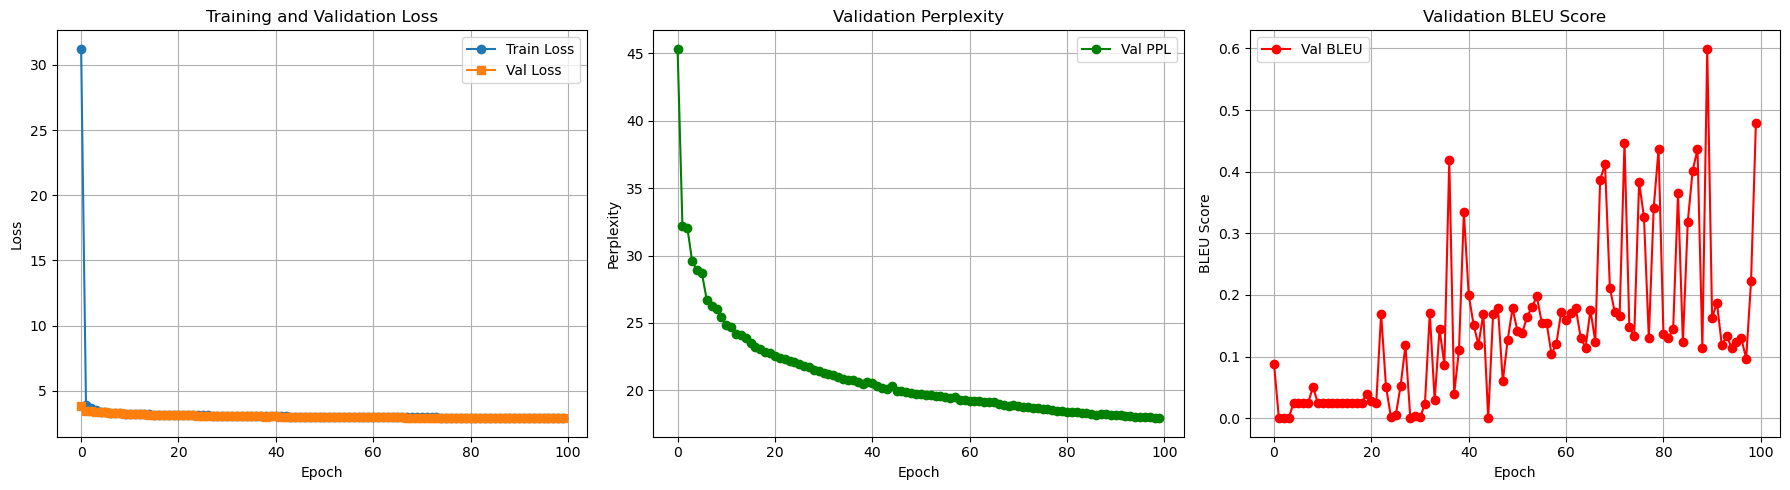


Final Results:
  Best Val BLEU: 0.60
  Final Val Loss: 2.887
  Final Val PPL: 17.93


In [104]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# PPL
axes[1].plot(history['val_ppl'], label='Val PPL', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].legend()
axes[1].grid(True)

# BLEU
axes[2].plot(history['val_bleu'], label='Val BLEU', marker='o', color='red')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('BLEU Score')
axes[2].set_title('Validation BLEU Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Best Val BLEU: {max(history['val_bleu']):.2f}")
print(f"  Final Val Loss: {history['val_loss'][-1]:.3f}")
print(f"  Final Val PPL: {history['val_ppl'][-1]:.2f}")





Attention Map 시각화

Cross-Attention을 시각화

In [106]:
# Attention Map 시각화 함수

# 한글 폰트 설정
try:
    import platform
    if platform.system() == 'Darwin':  # macOS
        rc('font', family='AppleGothic')
    elif platform.system() == 'Windows':
        rc('font', family='Malgun Gothic')
    else:  # Linux (Colab 등)
        rc('font', family='NanumGothic')
    plt.rcParams['axes.unicode_minus'] = False
except:
    print("Warning: 한글 폰트 설정 실패")


def display_attention(src_tokens, tgt_tokens, attention, n_heads=4, figsize=(16, 8)):
    """
    Cross-Attention Map을 시각화합니다.
    """
    src_clean = [t.replace('▁', ' ').strip() or '_' for t in src_tokens]
    tgt_clean = [t.replace('▁', ' ').strip() or '_' for t in tgt_tokens]

    max_len = 25
    src_clean = src_clean[:max_len]
    tgt_clean = tgt_clean[:max_len]

    n_heads = min(n_heads, attention.shape[0])
    n_cols = min(4, n_heads)
    n_rows = (n_heads + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_heads == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(n_heads):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]

        attn = attention[i][:len(tgt_clean), :len(src_clean)].numpy()

        im = ax.matshow(attn, cmap='Blues', aspect='auto')

        ax.set_xticks(range(len(src_clean)))
        ax.set_xticklabels(src_clean, rotation=90, fontsize=9)
        ax.set_yticks(range(len(tgt_clean)))
        ax.set_yticklabels(tgt_clean, fontsize=9)

        ax.set_xlabel('Source (Korean)', fontsize=10)
        ax.set_ylabel('Target (English)', fontsize=10)
        ax.set_title(f'Head {i+1}', fontsize=11, fontweight='bold')
        ax.xaxis.set_ticks_position('bottom')

    for i in range(n_heads, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


def visualize_attention_avg(src_tokens, tgt_tokens, attention, figsize=(12, 8)):
    """
    모든 head의 평균 Attention Map을 시각화합니다.
    """
    src_clean = [t.replace('▁', ' ').strip() or '_' for t in src_tokens]
    tgt_clean = [t.replace('▁', ' ').strip() or '_' for t in tgt_tokens]

    max_len = 30
    src_clean = src_clean[:max_len]
    tgt_clean = tgt_clean[:max_len]

    attn_avg = attention.mean(dim=0)[:len(tgt_clean), :len(src_clean)].numpy()

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.matshow(attn_avg, cmap='YlOrRd', aspect='auto')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(range(len(src_clean)))
    ax.set_xticklabels(src_clean, rotation=45, ha='left', fontsize=10)
    ax.set_yticks(range(len(tgt_clean)))
    ax.set_yticklabels(tgt_clean, fontsize=10)

    ax.set_xlabel('Source (Korean', fontsize=12)
    ax.set_ylabel('Target (English)', fontsize=12)
    ax.set_title('Average Attention Map (All Heads)', fontsize=14, fontweight='bold')
    ax.xaxis.set_ticks_position('bottom')

    plt.tight_layout()
    plt.show()

## 17. Test 평가

In [107]:
# Best 모델 로드
print("=" * 60)
print("Best 모델 로드")
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Epoch {checkpoint['epoch']+1} 모델 로드 완료")
print(f"Val BLEU: {checkpoint['val_bleu']:.2f}")
print("=" * 60)

# Test Loss
test_loss = evaluate(model, test_loader, criterion, device)
test_ppl = math.exp(min(test_loss, 100))

# Test BLEU (Greedy)
print("\nTest BLEU 계산 중 (Greedy Decoding)...")
test_bleu_greedy = evaluate_bleu(model, test_loader, vocab_kor, vocab_eng, device,
                                 num_samples=500, use_beam_search=False)

# Test BLEU (Beam Search)
print("Test BLEU 계산 중 (Beam Search)...")
test_bleu_beam = evaluate_bleu(model, test_loader, vocab_kor, vocab_eng, device,
                               num_samples=500, use_beam_search=True)

print("Test Results:")
print(f"  Test Loss: {test_loss:.3f}")
print(f"  Test PPL:  {test_ppl:.2f}")
print(f"  Test BLEU (Greedy):      {test_bleu_greedy:.2f}")
print(f"  Test BLEU (Beam Search): {test_bleu_beam:.2f}")
print(f"  Beam Search 개선: +{test_bleu_beam - test_bleu_greedy:.2f}")


Best 모델 로드


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL easydict.EasyDict was not an allowed global by default. Please use `torch.serialization.add_safe_globals([easydict.EasyDict])` or the `torch.serialization.safe_globals([easydict.EasyDict])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

## 18. 번역 예시

In [118]:
# 샘플 번역
print("=" * 60)
print("번역 예시 (Beam Search)")
print("=" * 60)

sample_sentences = [
    '안녕하세요, 저는 대통령이에요.',
  '개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
'모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
'그러나 이것은 또한 책상도 필요로 하지 않는다.',
'79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
'정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.',
'이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.',
'국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.',
'이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.',
'"결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."',
'연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.',
'약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이 이번 연구에서 밝혀졌다.',
'의약 연구소는 정부에 과학 문제에 관해 자문하기 위해 의회가 설립 인가를 내어 준 민간 단체인 국립 과학 학회의 부속 단체이다.',
'아시아에서의 왕성한 수요 덕분에 일본의 수출이 9월에 연속 6개월간 증가하여, 무역 흑자가 1조550억엔(84억7,000만달러)으로 늘어났다고 재무성이 발표했다.',
'그러나 침체되고 있는 미국 경제와 국내 수요의 약세 전망이 향후 수개월 동안의 낙관론을 어둡게 했다.',
'특수 부대가 극장 건물로 공격해 들어가면서, 러시아인이 아닌 75명의 외국인과 25명의 어린이 전부를 포함해 750명 이상의 인질들이 구출되었다.',
'러시아 특수 부대는 극장으로 공격해 들어가기 전에 신경 독가스를 사용했다.',
'많은 인질들이 화학 가스의 영향으로 고통을 겪으며 병원으로 옮겨졌다.',
'과거 노조 지도자였던 루이스 이나시오 룰라 다 실바가 브라질의 대통령 선거 결선 투표에서 압승을 거두면서, 라틴 아메리카 최대 국가로서는 좌파로의 역사적인 전환을 맞이하게 되었다.'
]

for kor_sent in sample_sentences:
    eng_translation = translate_sentence(kor_sent, model, vocab_kor, vocab_eng, device,
                                        use_beam_search=True, beam_size=5)
    print(f"\nkorean: {kor_sent}")
    print(f"eng: {eng_translation}")



번역 예시 (Beam Search)

korean: 안녕하세요, 저는 대통령이에요.
eng: "we's not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not

korean: 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
eng: "i's very't said.

korean: 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
eng: "we's very, i't said.

korean: 그러나 이것은 또한 책상도 필요로 하지 않는다.
eng: "i's not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not not

korean: 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
eng: "i's very't said.

korean: 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
eng: "we's very, but he said he said.

korean: 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가

## 19. 대화형 번역기

In [119]:
def interactive_translate():
    """대화형 번역 함수"""
    print("=" * 60)
    print("대화형 번역기")
    print("종료하려면 'quit' 또는 'exit'를 입력하세요")
    print("=" * 60)

    while True:
        kor_input = input("\n한국어 입력: ").strip()

        if kor_input.lower() in ['quit', 'exit', '']:
            print("번역기를 종료합니다.")
            break

        try:
            translation = translate_sentence(kor_input, model, vocab_kor, vocab_eng, device,
                                           use_beam_search=True, beam_size=5)
            print(f"eng 번역: {translation}")
        except Exception as e:
            print(f"오류 발생: {e}")

# 실행
print("interactive_translate() 함수를 호출하여 대화형 번역을 시작하세요!")


interactive_translate() 함수를 호출하여 대화형 번역을 시작하세요!


어텐션 맵 시각화 진행

Attention Map 시각화

원문 (korean): 오바마 대통령은 말했다
번역 (english): the u.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s.s
Source tokens: ['<s>', '▁오바마', '▁대통령은', '▁말했다', '</s>']
Target tokens: ['<s>', '▁the', '▁u', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's', '.', 's']

[Head별 Attention Map]


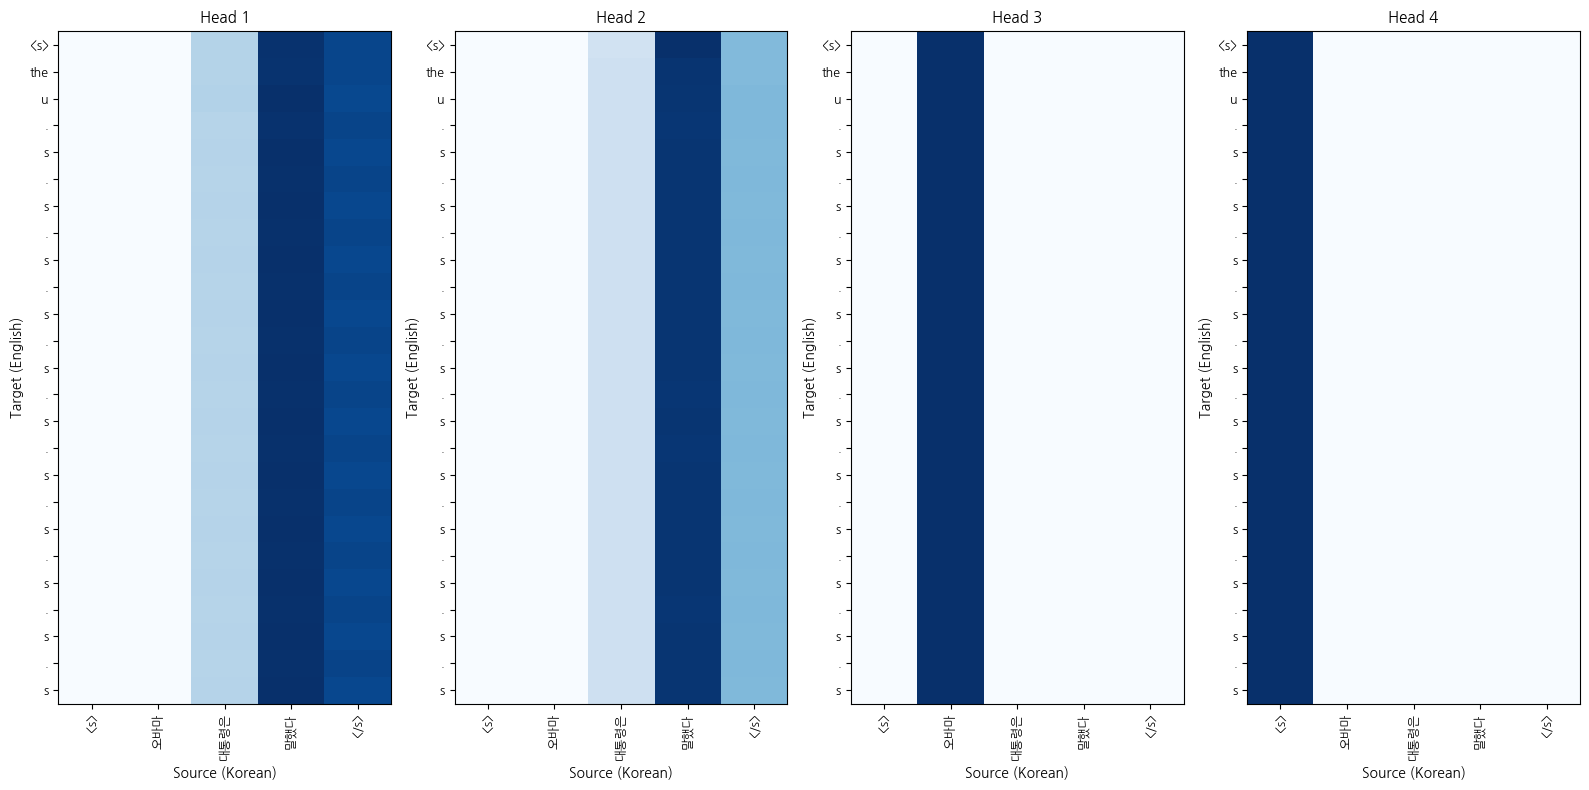


[평균 Attention Map]


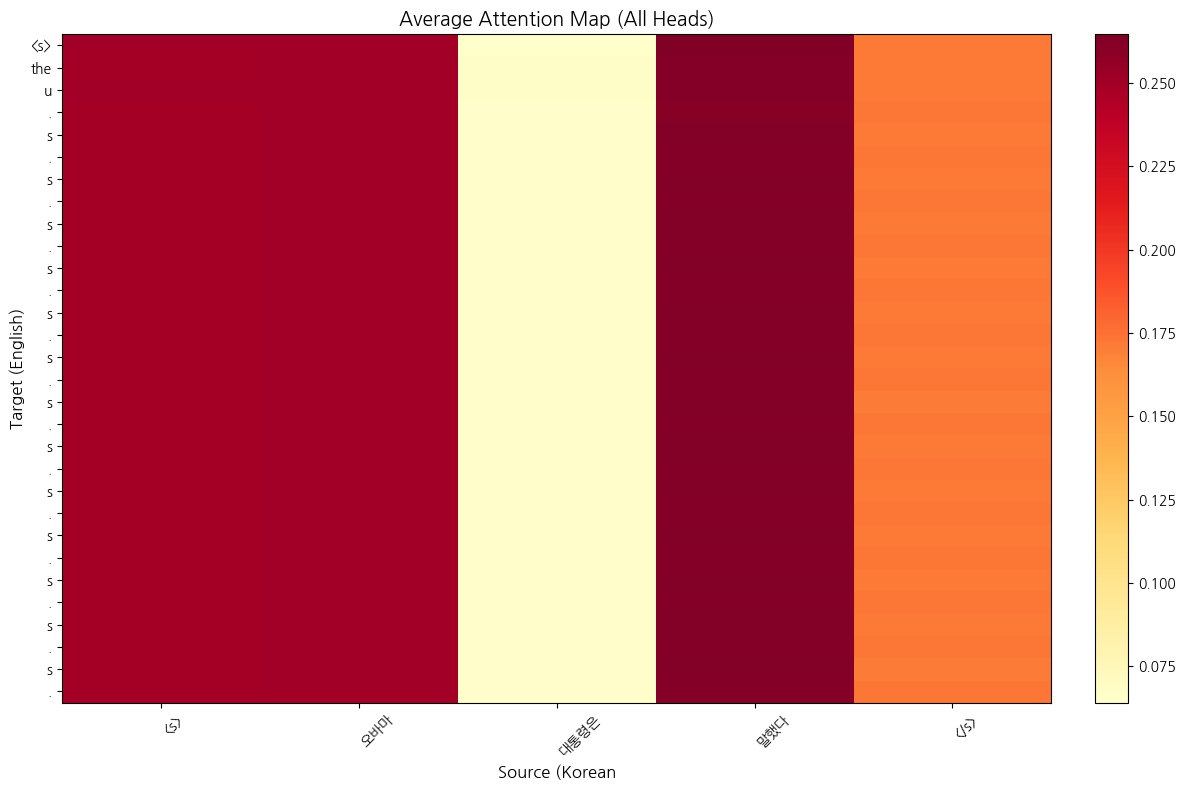


원문 (korean): 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
번역 (english): the new york, the first time, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new
Source tokens: ['<s>', '▁개인', '용', '▁컴퓨터', '▁사용', '의', '▁상당', '▁부분은', '▁"', '이', '것', '보다', '▁뛰어', '날', '▁수', '▁있느냐', '?', '"', '</s>']
Target tokens: ['<s>', '▁the', '▁new', '▁york', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new']

[Head별 Attention Map]


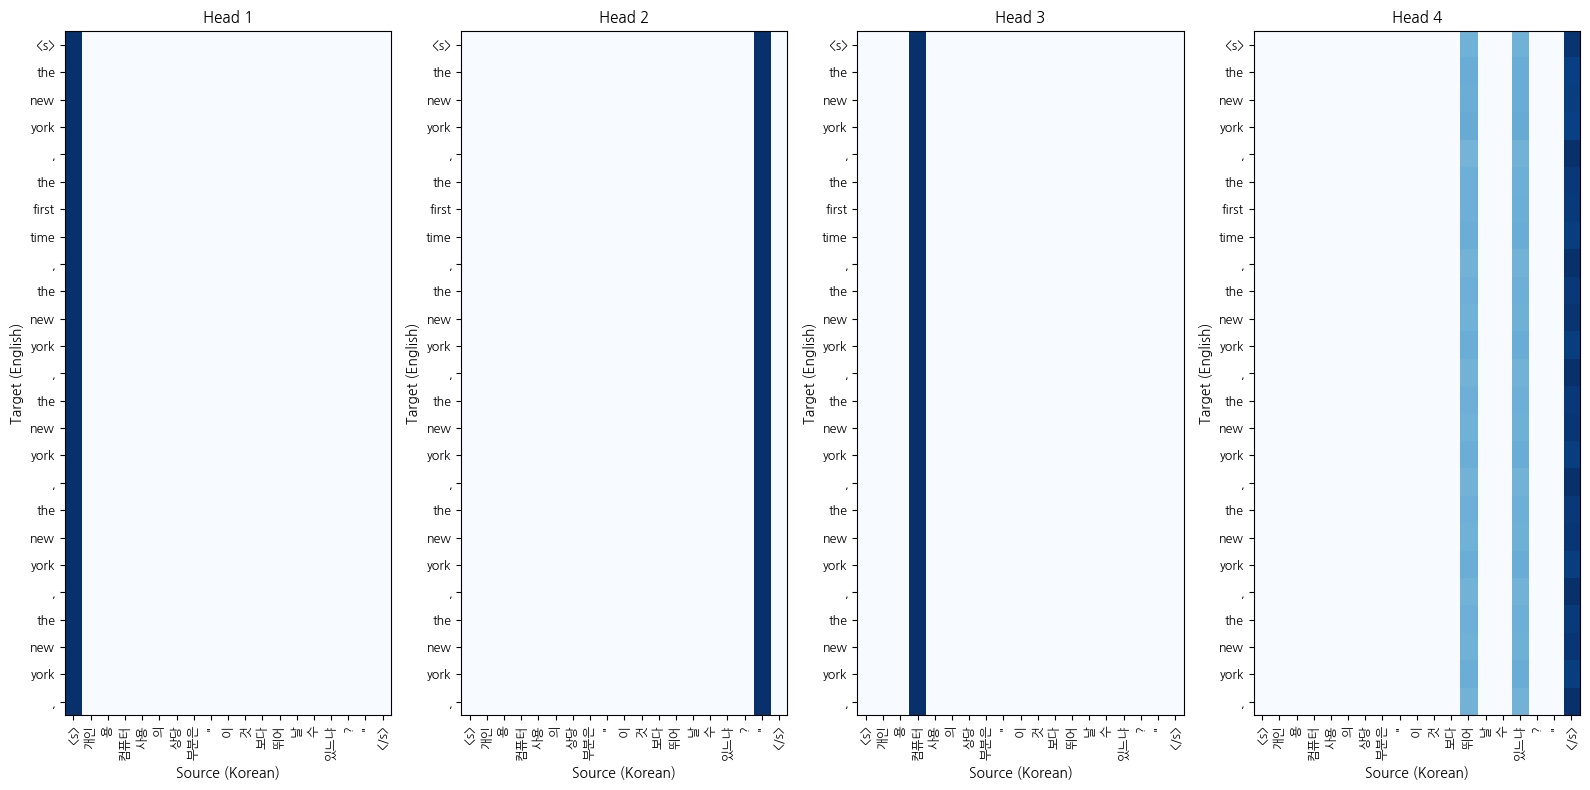


[평균 Attention Map]


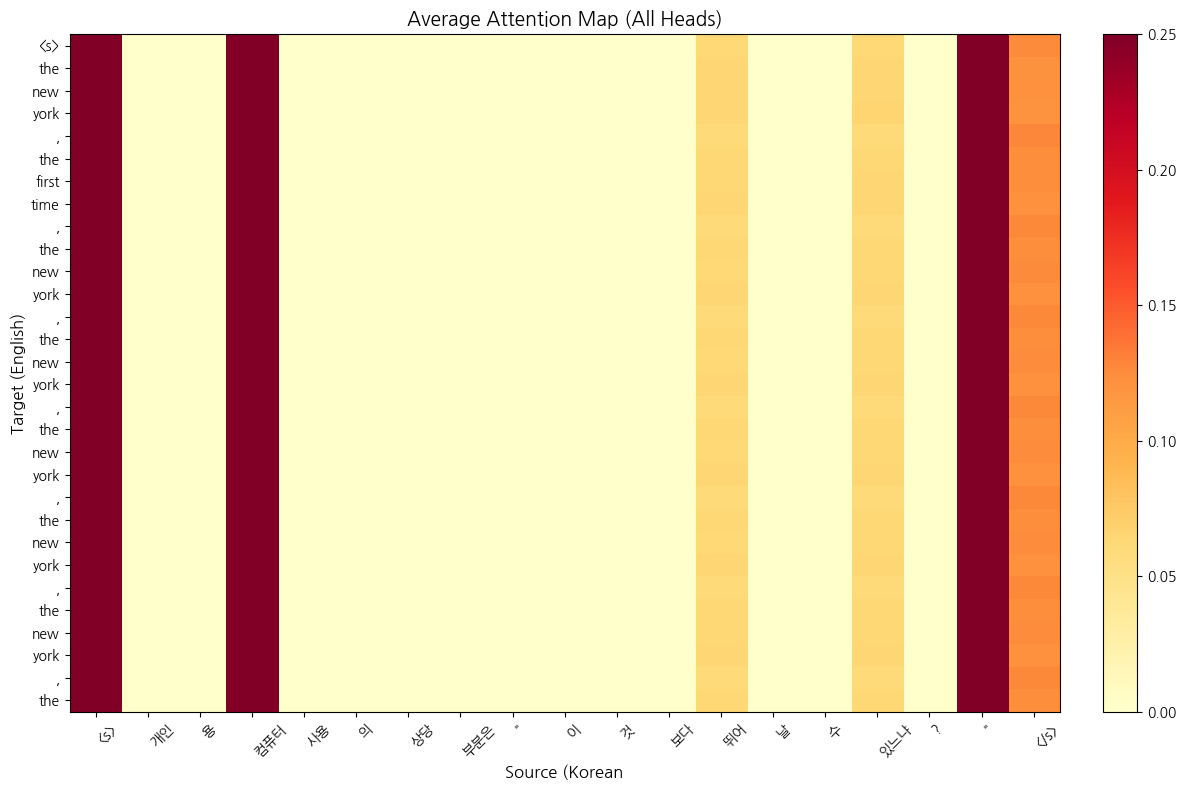


원문 (korean): 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
번역 (english): the new york, the first time, the first time, the first time, the first time, the first time, the first time, the first time, the first time, the first time, the first time, the first time, the first
Source tokens: ['<s>', '▁모든', '▁광', '마', '우', '스와', '▁마찬가지', '▁로', '▁이', '▁광', '마', '우스', '도', '▁책', '상', '▁위에', '▁놓', '는', '▁마', '우스', '▁패', '드를', '▁필요로', '▁하지', '▁않는다', '.', '</s>']
Target tokens: ['<s>', '▁the', '▁new', '▁york', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first']

[Head별 Attention Map]


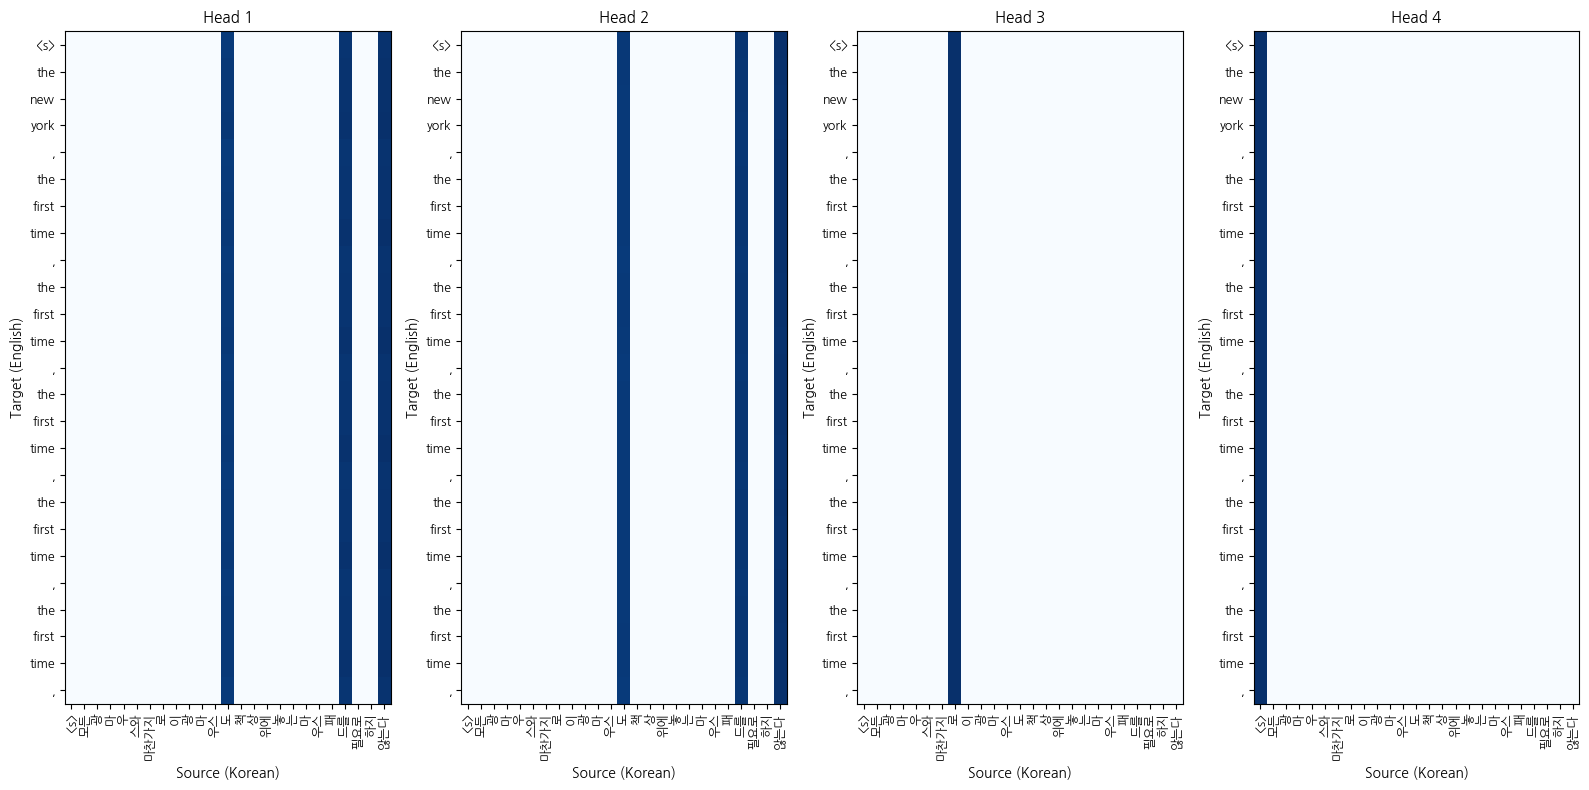


[평균 Attention Map]


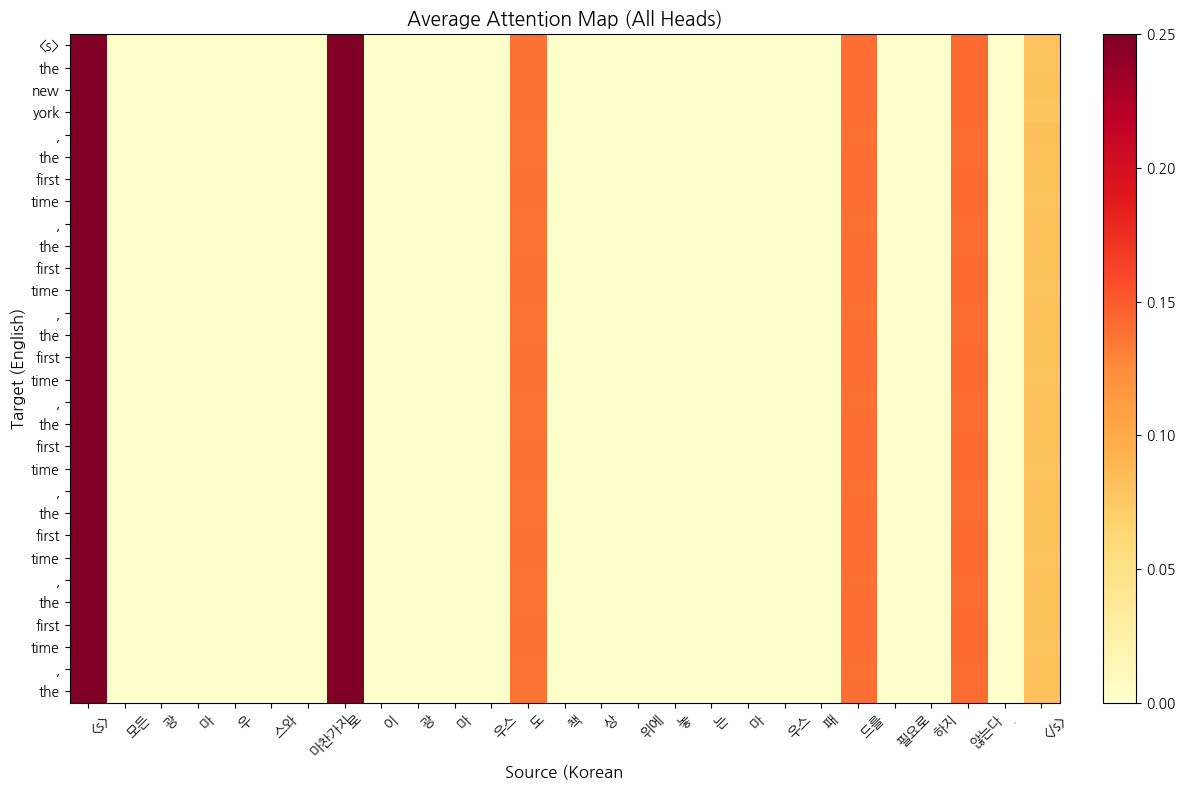


원문 (korean): 그러나 이것은 또한 책상도 필요로 하지 않는다.
번역 (english): the korea is the government to the united states.
Source tokens: ['<s>', '▁그러나', '▁이것은', '▁또한', '▁책', '상도', '▁필요로', '▁하지', '▁않는다', '.', '</s>']
Target tokens: ['<s>', '▁the', '▁korea', '▁is', '▁the', '▁government', '▁to', '▁the', '▁united', '▁states', '.', '</s>']

[Head별 Attention Map]


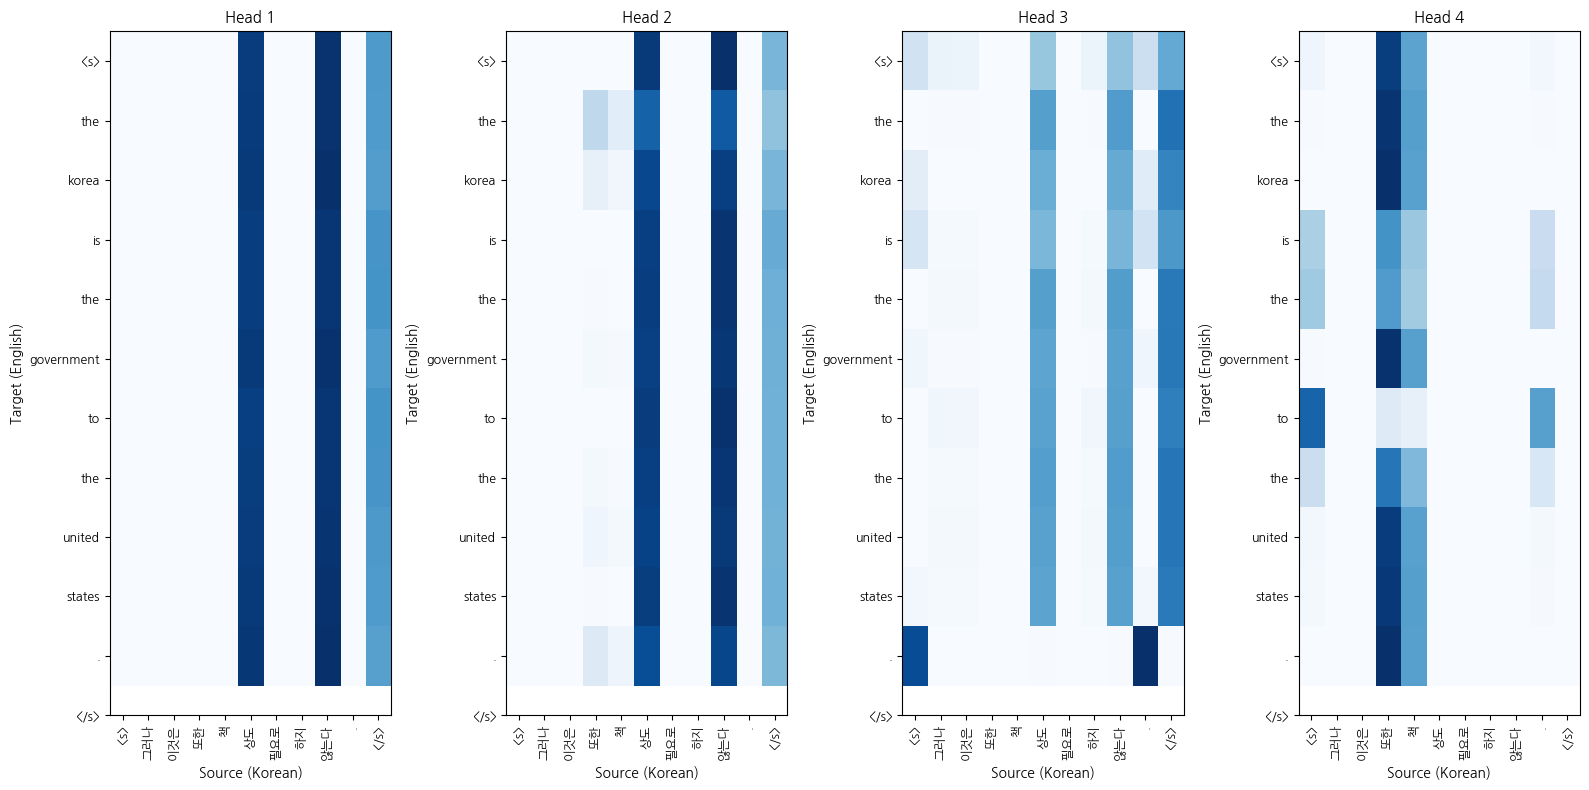


[평균 Attention Map]


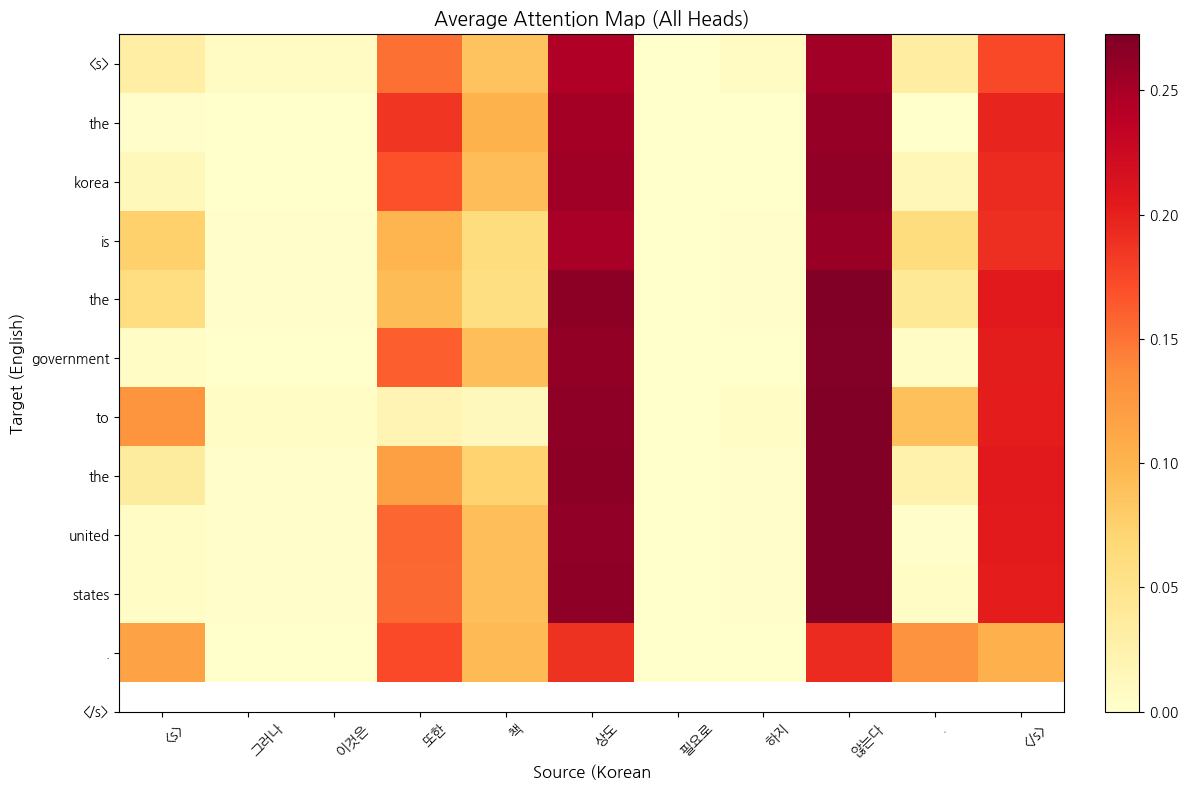


원문 (korean): 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
번역 (english): the 199999999999999999999999999999999999999999999999
Source tokens: ['<s>', '▁', '7', '9', '.', '9', '5', '달러', '하는', '▁이', '▁최첨단', '▁무선', '▁광', '마', '우', '스는', '▁허', '공', '에서', '▁팔', '목', ',', '▁팔', ',', '▁그', '외', '에', '▁어떤', '▁부분이', '든', '▁그', '▁움직임', '에따라', '▁커', '서의', '▁움직임을', '▁조절', '하는', '▁회', '전', '▁운동', '▁센', '서를', '▁사용하고', '▁있다', '.', '</s>']
Target tokens: ['<s>', '▁the', '▁', '1', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9']

[Head별 Attention Map]


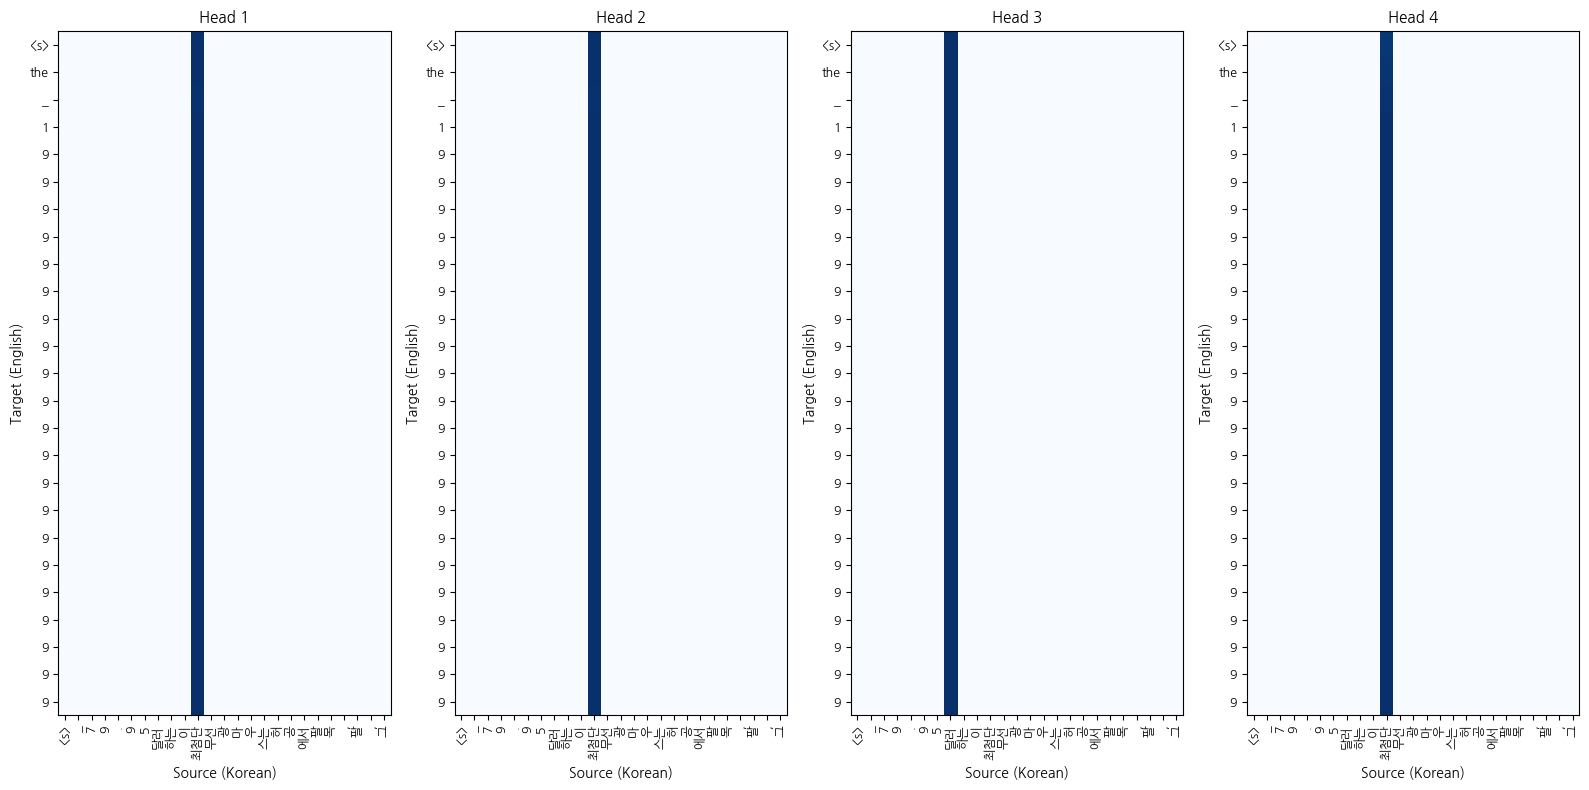


[평균 Attention Map]


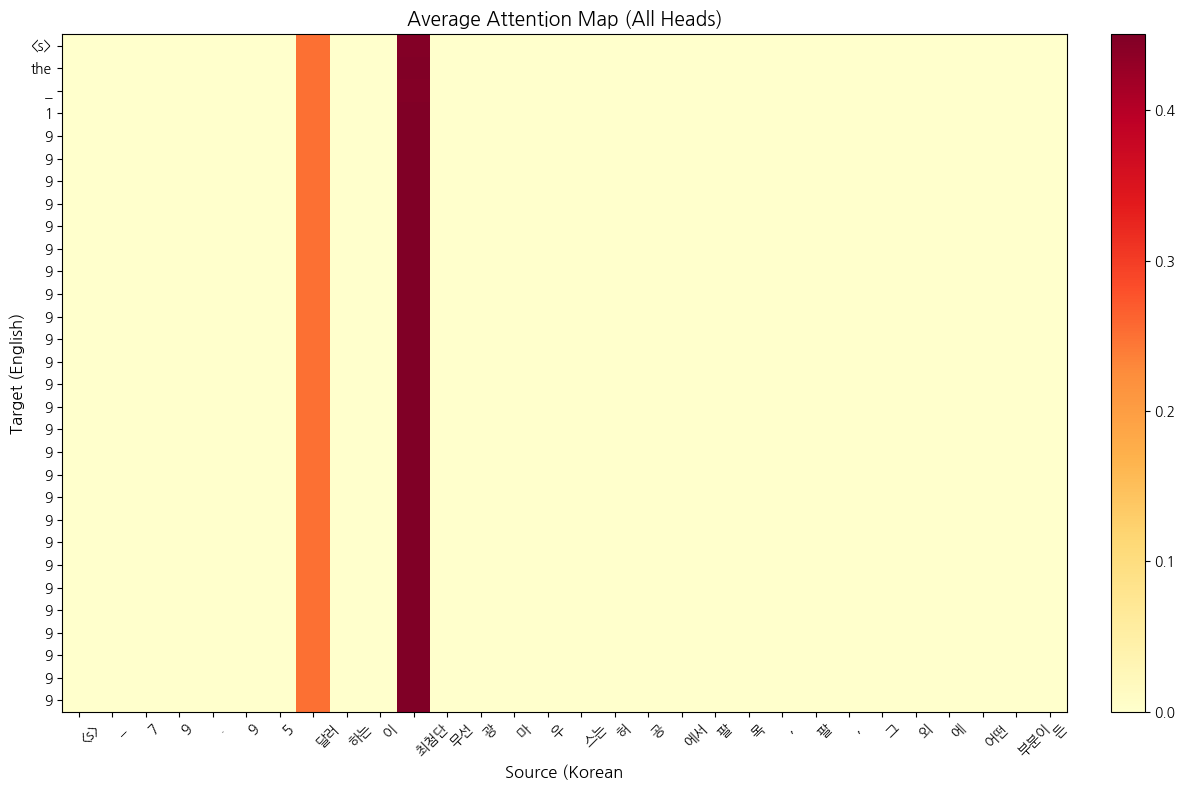


원문 (korean): 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
번역 (english): the 199999999999999999999999999999999999999999999999
Source tokens: ['<s>', '▁정보', '▁관리들은', '▁동남', '▁아시아', '에서의', '▁선박', '들에', '▁대한', '▁많은', '▁(', '테러', ')', '▁계획', '들이', '▁실패', '로', '▁돌아', '갔', '음을', '▁밝혔으며', ',', '▁세계', '▁해상', '▁교', '역', '량의', '▁거의', '▁', '3', '분의', '▁', '1', '을', '▁운송', '하는', '▁좁은', '▁해', '로', '인', '▁말라', '카', '▁해협', '이', '▁테러', '▁공격을', '▁당', '하기', '▁쉽', '다고', '▁경고', '하고', '▁있다', '.', '</s>']
Target tokens: ['<s>', '▁the', '▁', '1', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9', '9']

[Head별 Attention Map]


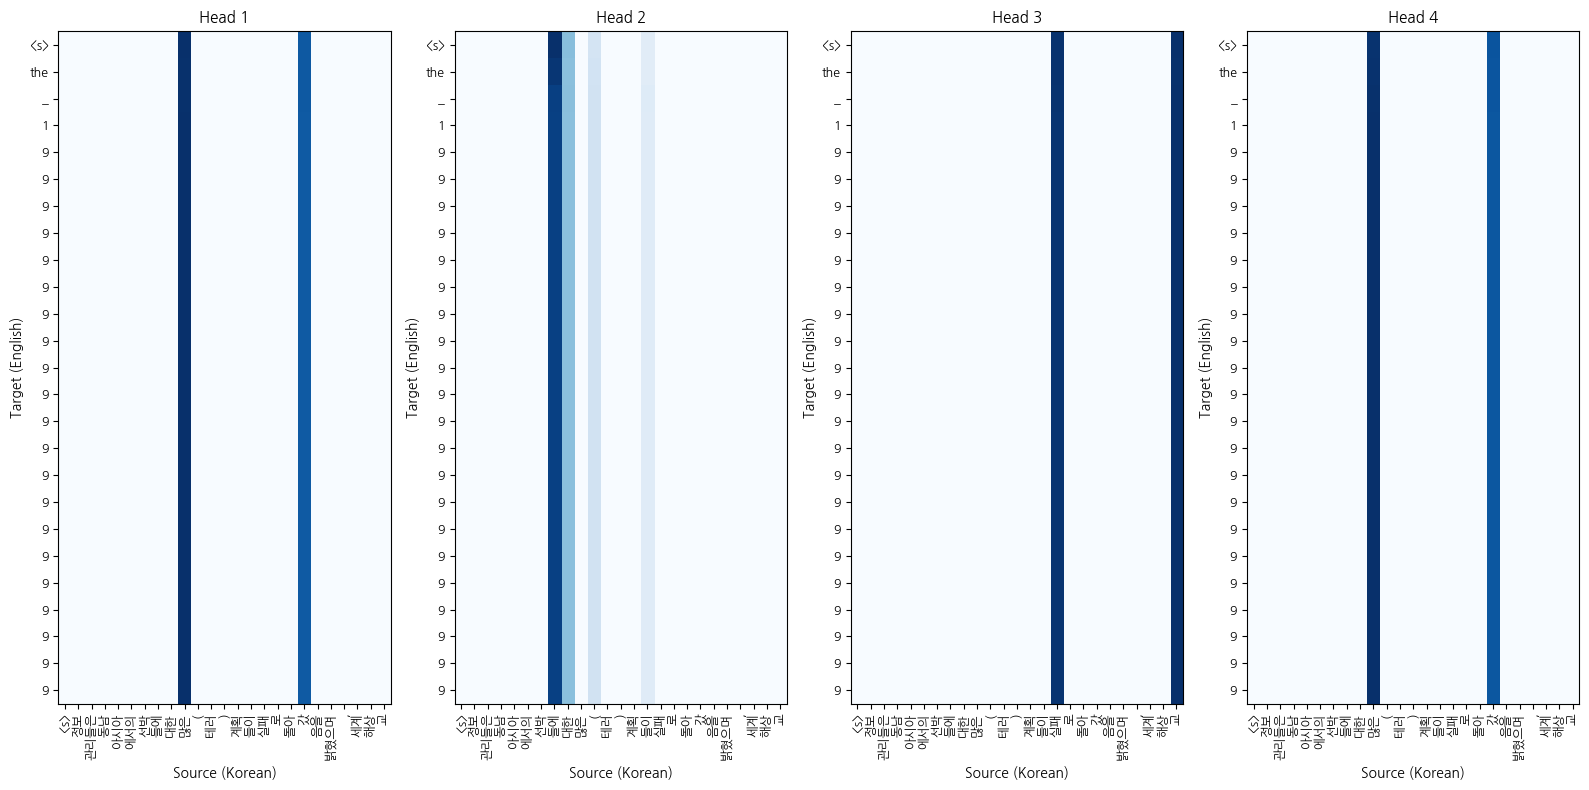


[평균 Attention Map]


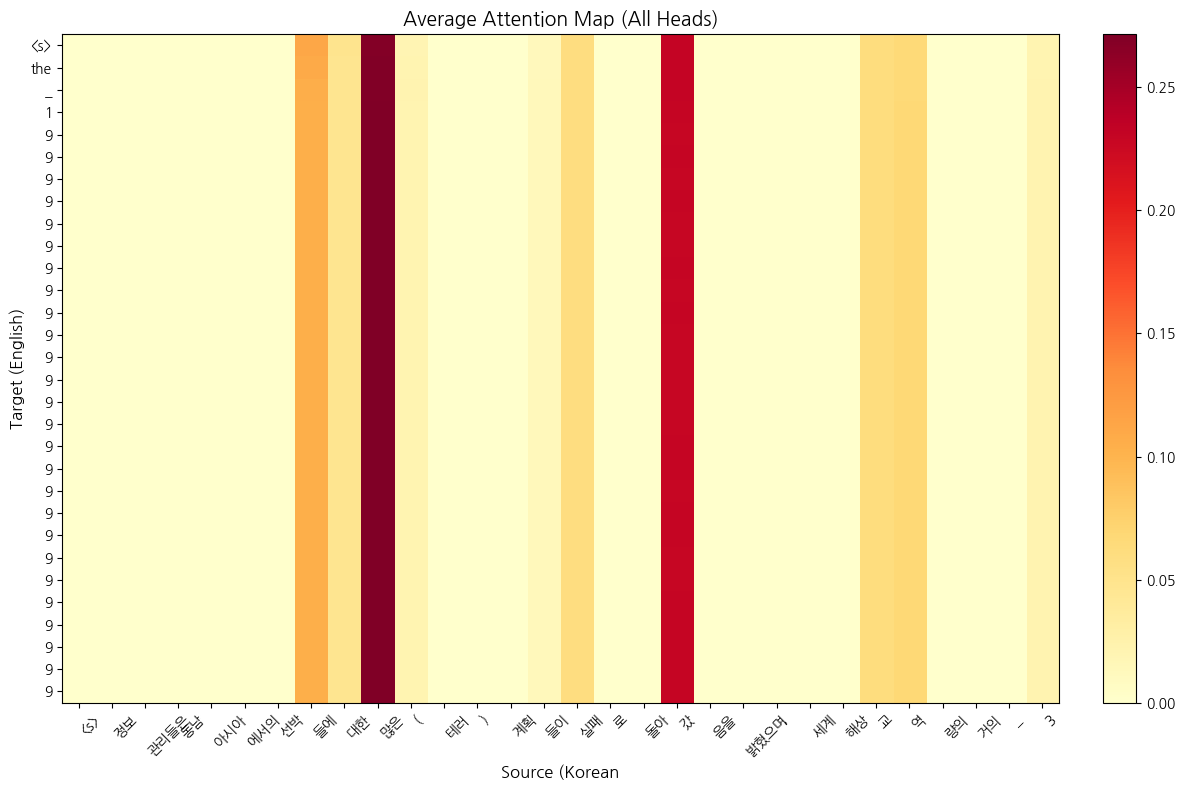


원문 (korean): 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
번역 (english): the new york, the first time, the new york, the first time, the first time, the first time, the first time, the first time, the first time, the first time, the first time, the first time, the first
Source tokens: ['<s>', '▁이', '▁지역에', '▁있는', '▁미국', '▁선박', '과', '▁상업', '용', '▁선박', '들에', '▁대한', '▁알카에다의', '▁(', '테러', ')', '▁시도', '▁중', '▁여러', '▁건', '이', '▁실패', '했다는', '▁것을', '▁알게', '▁된', '▁후에', ',', '▁전문가들은', '▁테러', '▁조직', '이', '▁여전히', '▁세계', '▁경제에', '▁타격을', '▁입', '히려', '▁한다고', '▁경고', '하고', '▁있으며', ',', '▁동남', '▁아시아', '에', '▁있는', '▁세계', '▁경제의', '▁주요', '▁통', '로가', '▁위험에', '▁처해', '▁있다고', '▁그들은', '▁생각하고', '▁있다', '.', '</s>']
Target tokens: ['<s>', '▁the', '▁new', '▁york', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁first', '▁time', ',', '▁the'

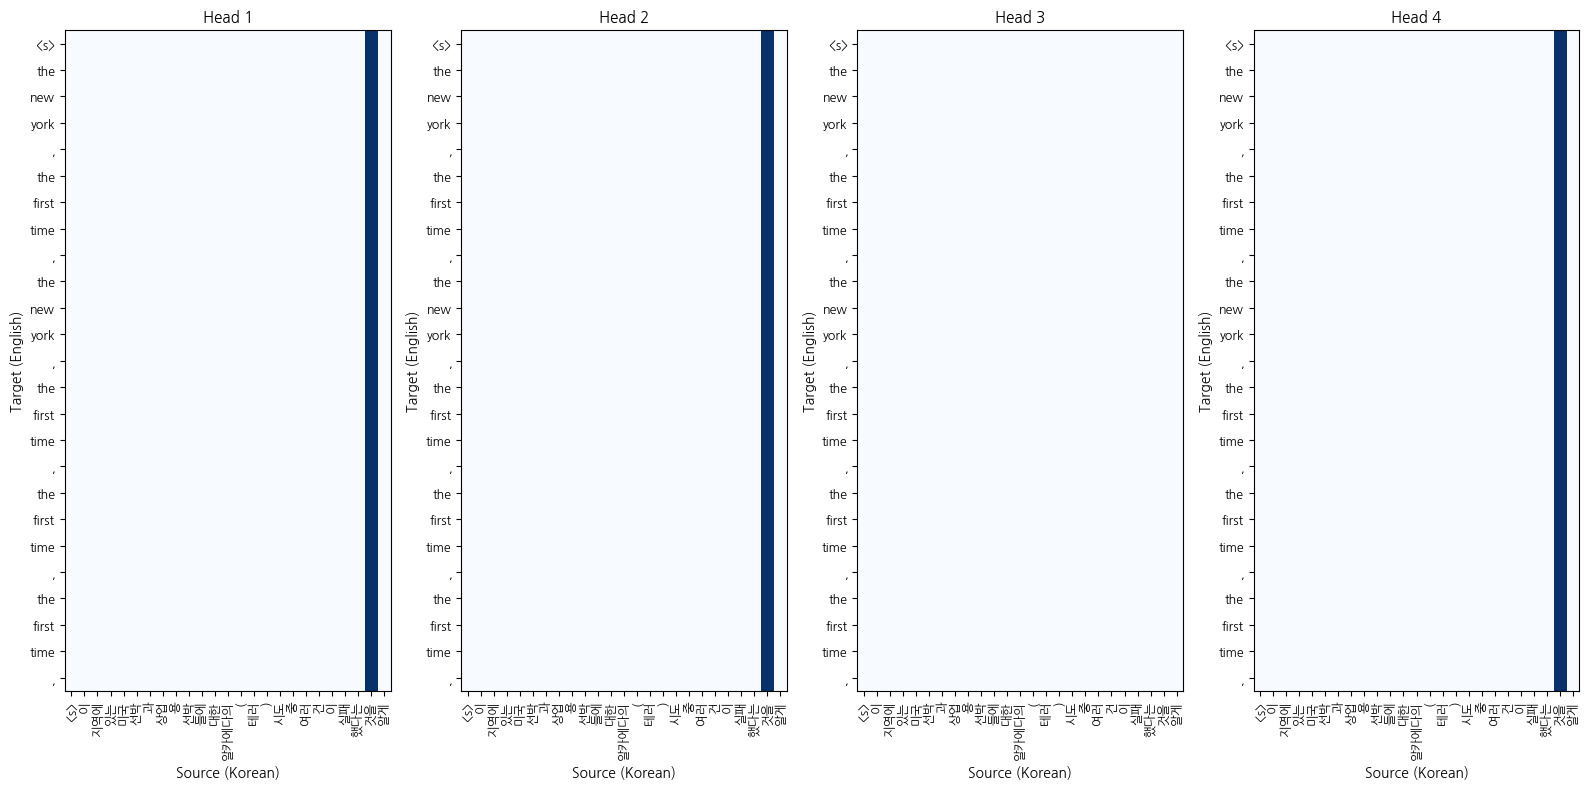


[평균 Attention Map]


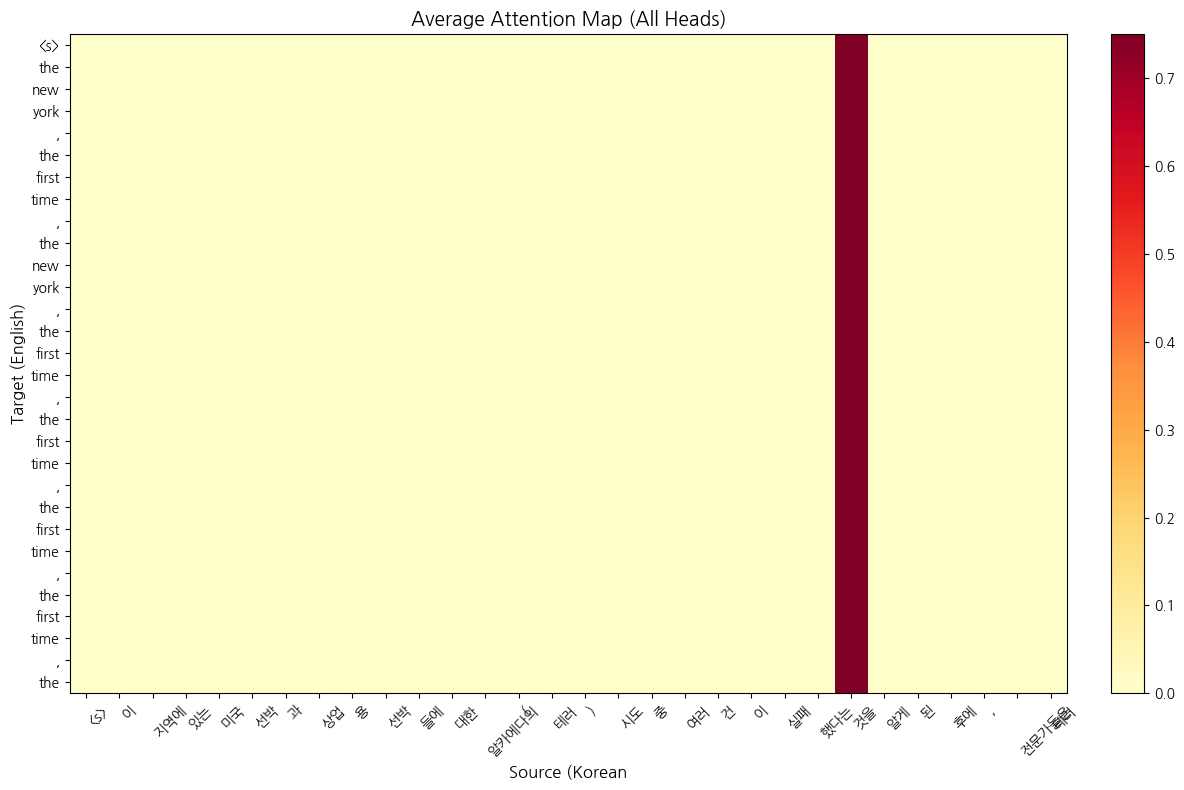


원문 (korean): 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
번역 (english): the new york, the first time, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new
Source tokens: ['<s>', '▁국립', '▁과학', '▁학', '회가', '▁발표한', '▁새', '▁보고서에따르면', ',', '▁복잡한', '▁임무를', '▁수행', '해야', '▁하는', '▁군인들이', '나', '▁보다', '▁오랜', '▁시간', '▁동안', '▁경계를', '▁늦', '추', '지', '▁않고', '▁있기', '▁위해', '▁도움이', '▁필요한', '▁군인', '들에게', '▁카페', '인이', '▁반응', '▁시간을', '▁증가', '시키고', '▁임무', '▁수행', '▁능력을', '▁향상', '시키는데', '▁도움이', '▁된다고', '▁한다', '.', '</s>']
Target tokens: ['<s>', '▁the', '▁new', '▁york', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new'

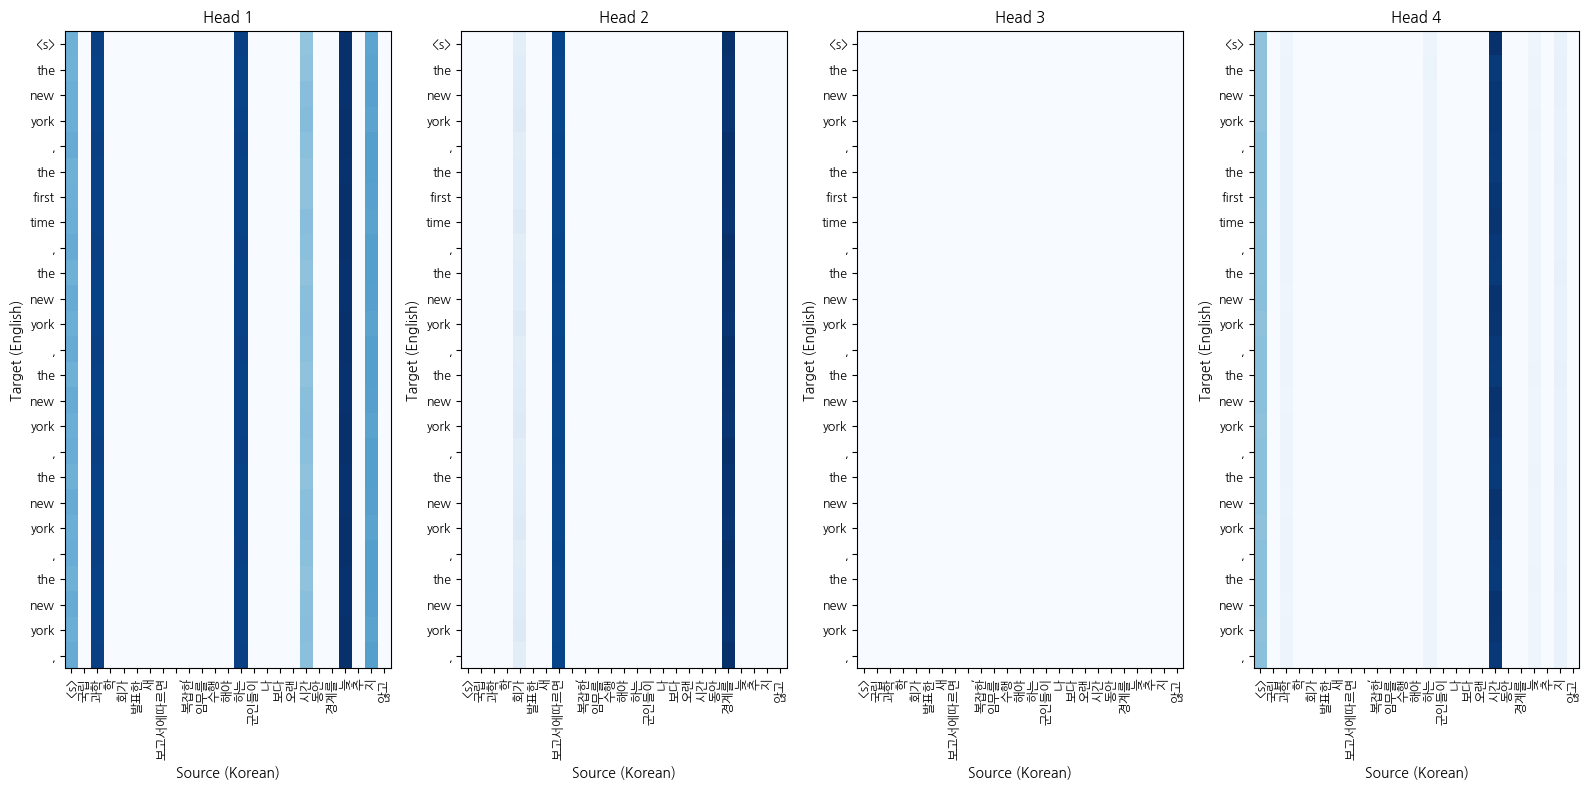


[평균 Attention Map]


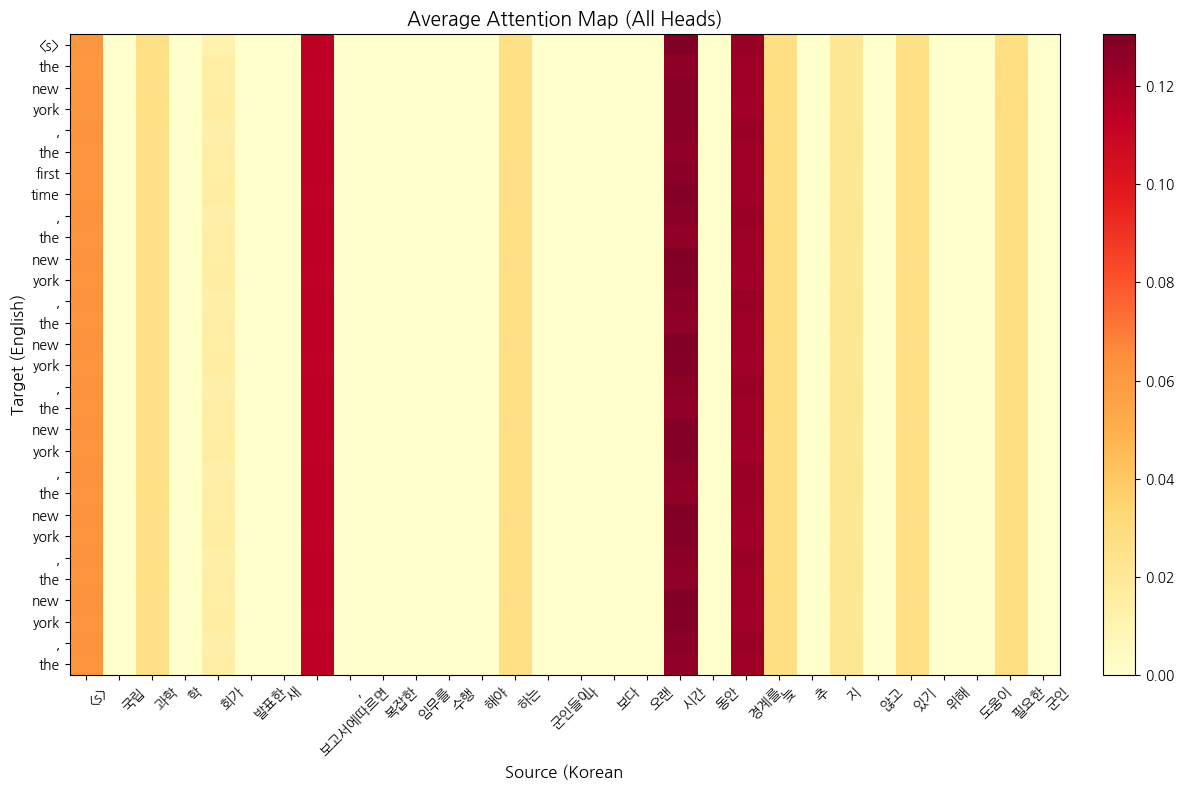


원문 (korean): 이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
번역 (english): the 100000000000000000000000000000000000000000000000
Source tokens: ['<s>', '▁이', '▁보고서에따르면', ',', '▁"', '특', '히', ',', '▁군사', '▁작', '전에서', '▁생', '사가', '▁걸린', '▁상황이', '▁될', '▁수도', '▁있는', '▁반응', '▁속', '도와', '▁시각', '▁및', '▁청', '각', '의', '▁경계', '▁상태를', '▁유지', '시키기', '▁위해', '▁카페', '인이', '▁사용될', '▁수도', '▁있다', '."', '▁고', '▁한다', '.', '</s>']
Target tokens: ['<s>', '▁the', '▁', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

[Head별 Attention Map]


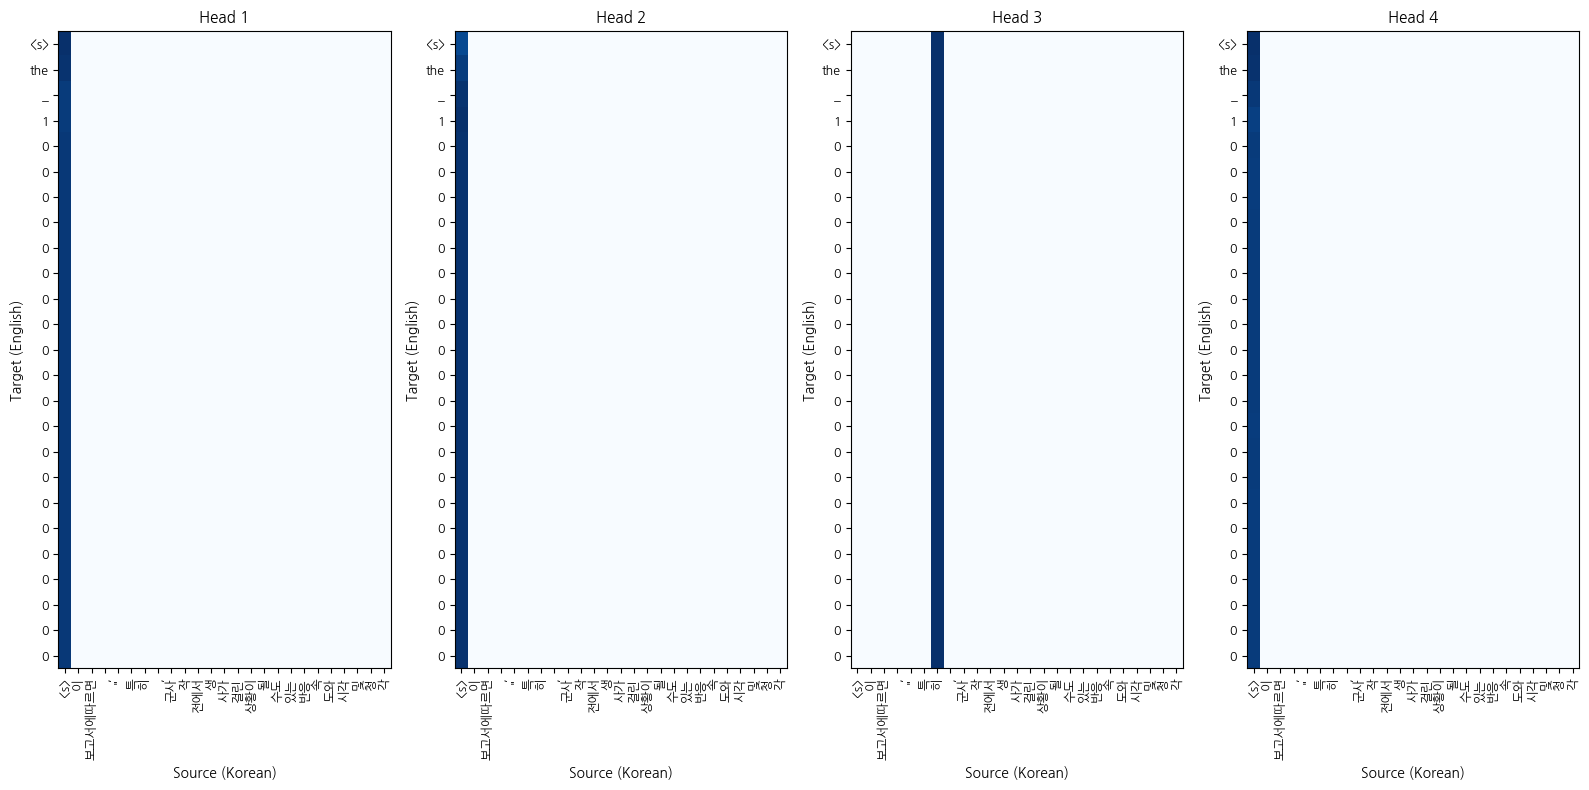


[평균 Attention Map]


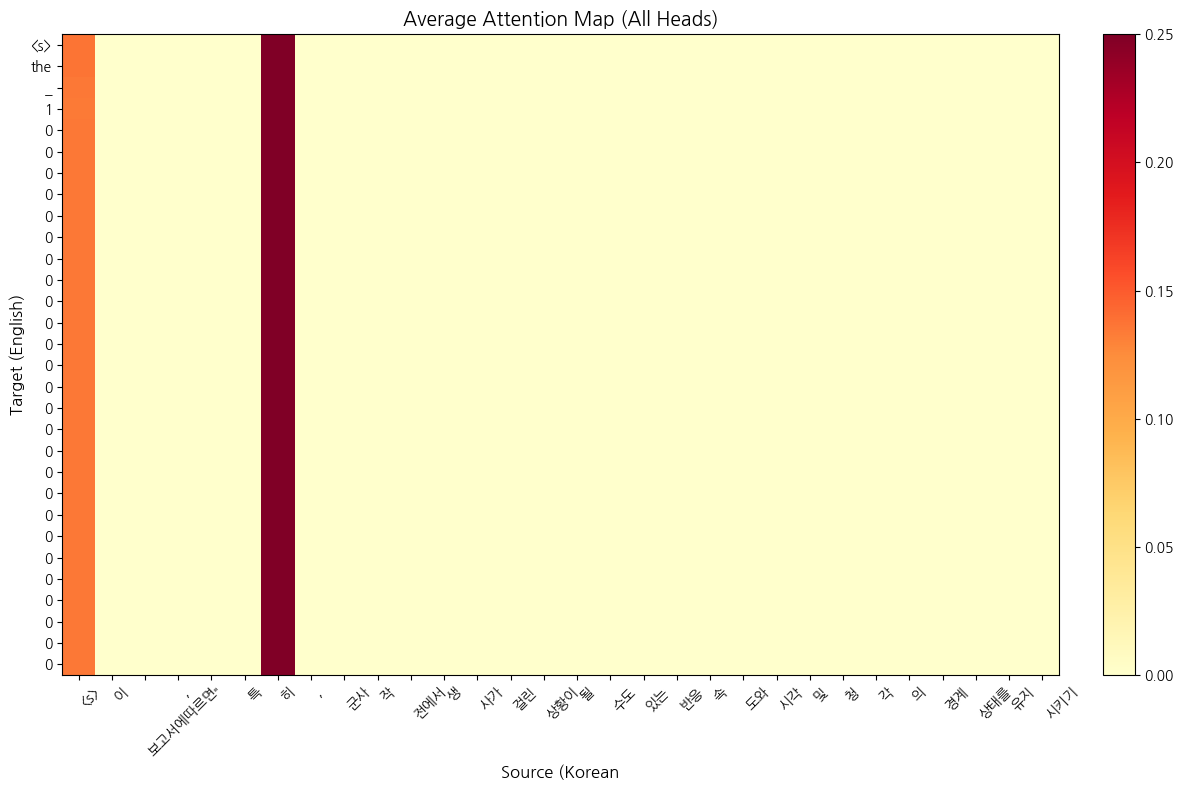


원문 (korean): "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
번역 (english): the new york, the first time, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new york, the new
Source tokens: ['<s>', '▁"', '결', '정적인', '▁순간', '에', '▁그들의', '▁능력을', '▁증가', '시켜', '▁줄', '▁그', '▁무엇이', '▁매우', '▁중요', '합니다', '."', '</s>']
Target tokens: ['<s>', '▁the', '▁new', '▁york', ',', '▁the', '▁first', '▁time', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new', '▁york', ',', '▁the', '▁new']

[Head별 Attention Map]


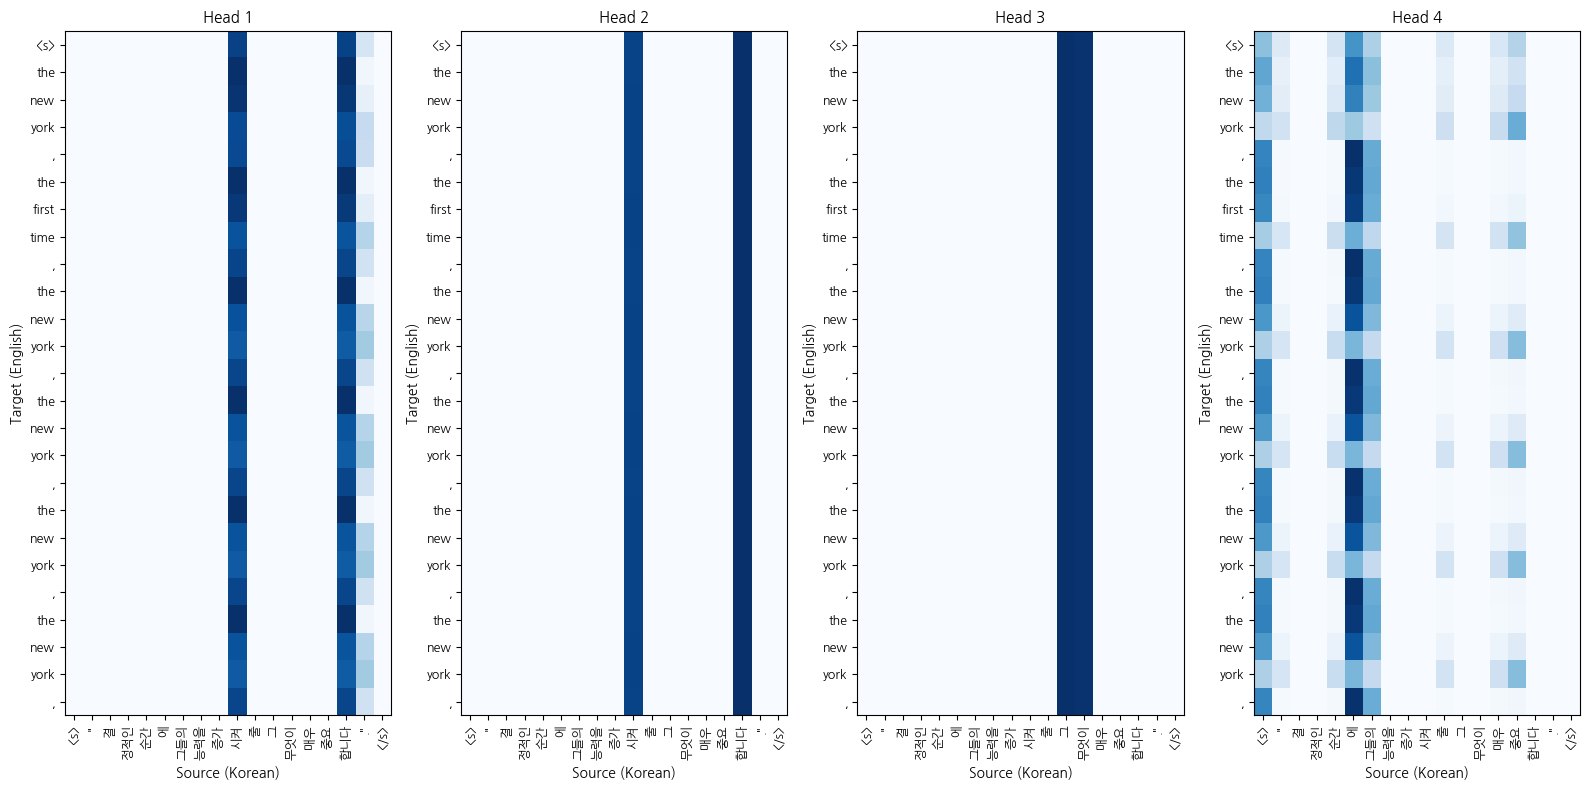


[평균 Attention Map]


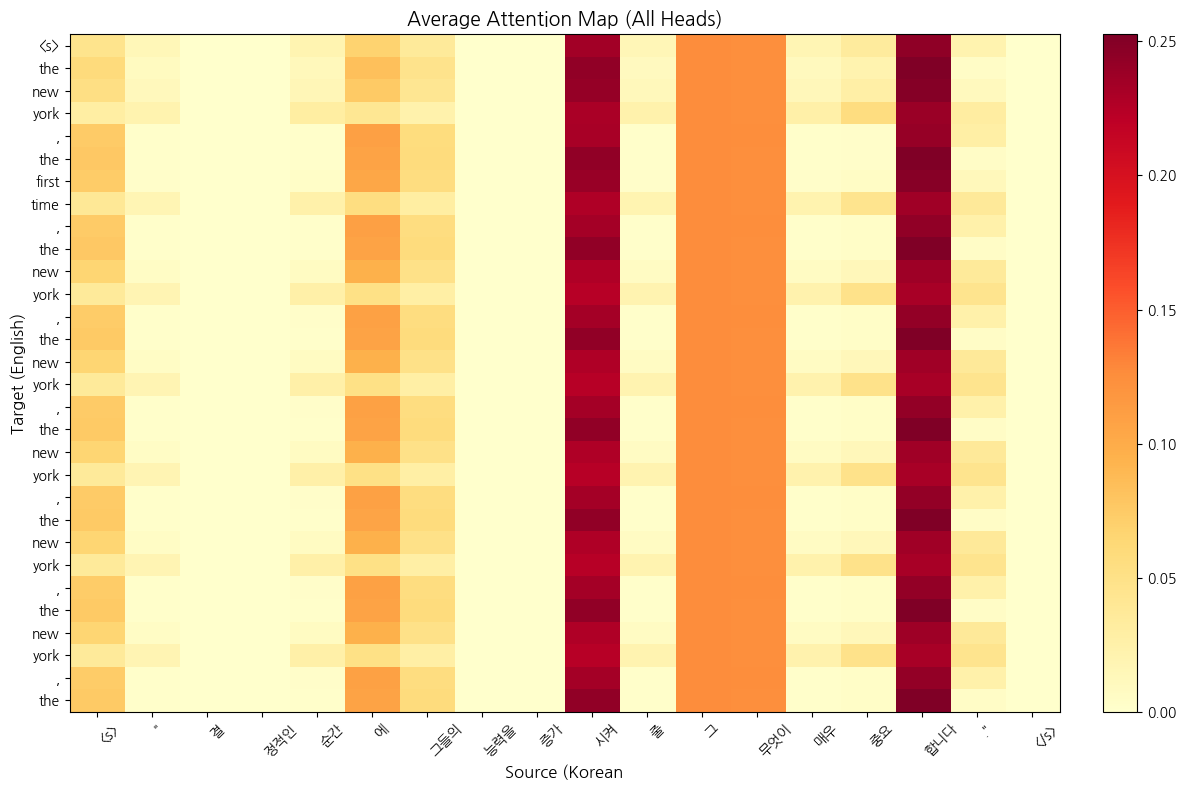


원문 (korean): 연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.
번역 (english): the 100000000000000000000000000000000000000000000000
Source tokens: ['<s>', '▁연구', '가들이', '▁이미', '▁커피', '▁대체', '품', '으로서', '▁음식', '▁대', '용', '▁과', '자나', '▁', '<0xEA>', '<0xBB>', '<0x8C>', '에', '▁카페', '인을', '▁첨', '가', '하는', '▁방법을', '▁연구', '하고', '▁있다고', '▁Ar', 'ch', 'ib', 'al', 'd', '는', '▁말했다', '.', '</s>']
Target tokens: ['<s>', '▁the', '▁', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

[Head별 Attention Map]


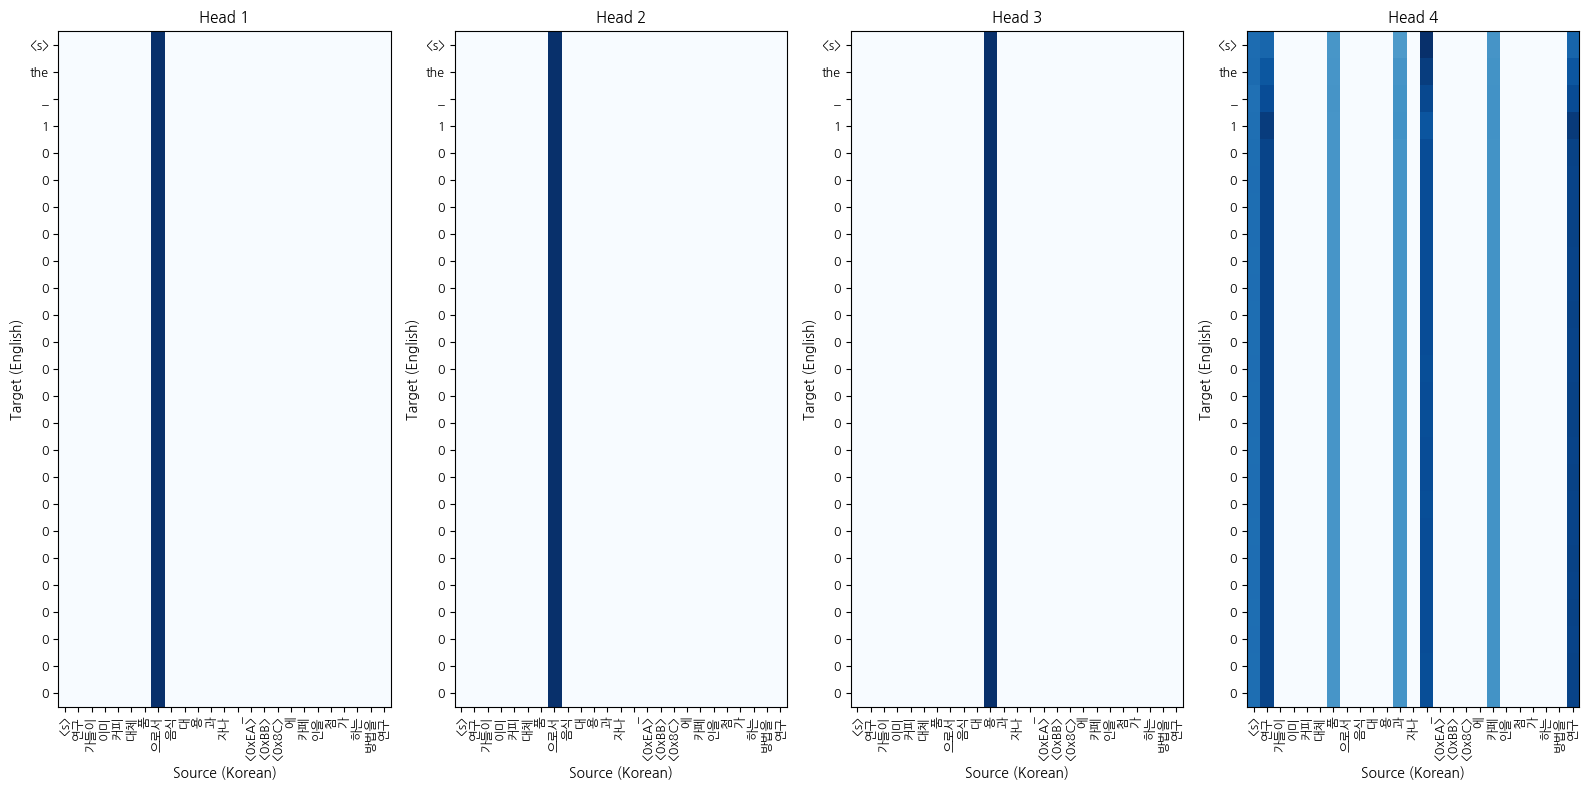


[평균 Attention Map]


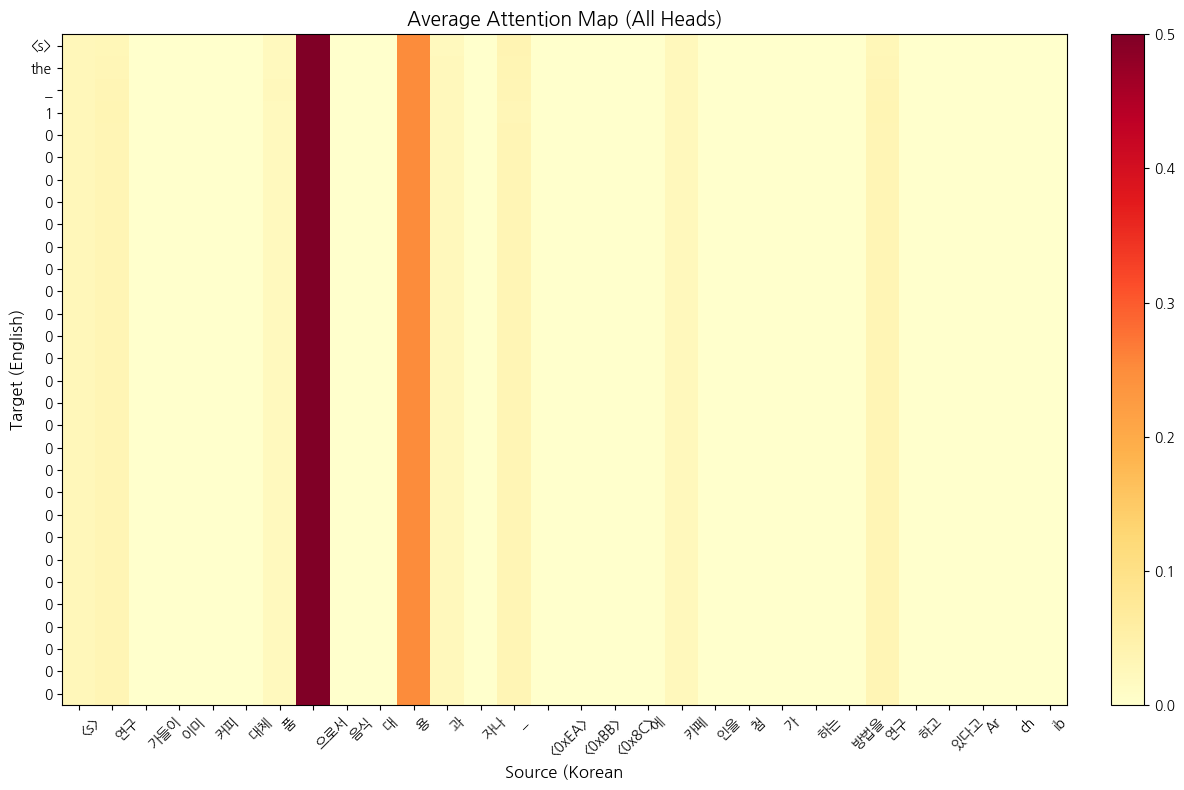

In [ ]:
# =============================================================================
# Attention Map 시각화 실행
# =============================================================================

sample_sentences = [
    '오바마 대통령은 말했다',
  '개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
'모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
'그러나 이것은 또한 책상도 필요로 하지 않는다.',
'79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
'정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.',
'이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.',
'국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.',
'이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.',
'"결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."',
'연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.',
'약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이 이번 연구에서 밝혀졌다.',
'의약 연구소는 정부에 과학 문제에 관해 자문하기 위해 의회가 설립 인가를 내어 준 민간 단체인 국립 과학 학회의 부속 단체이다.',
'아시아에서의 왕성한 수요 덕분에 일본의 수출이 9월에 연속 6개월간 증가하여, 무역 흑자가 1조550억엔(84억7,000만달러)으로 늘어났다고 재무성이 발표했다.',
'그러나 침체되고 있는 미국 경제와 국내 수요의 약세 전망이 향후 수개월 동안의 낙관론을 어둡게 했다.',
'특수 부대가 극장 건물로 공격해 들어가면서, 러시아인이 아닌 75명의 외국인과 25명의 어린이 전부를 포함해 750명 이상의 인질들이 구출되었다.',
'러시아 특수 부대는 극장으로 공격해 들어가기 전에 신경 독가스를 사용했다.',
'많은 인질들이 화학 가스의 영향으로 고통을 겪으며 병원으로 옮겨졌다.',
'과거 노조 지도자였던 루이스 이나시오 룰라 다 실바가 브라질의 대통령 선거 결선 투표에서 압승을 거두면서, 라틴 아메리카 최대 국가로서는 좌파로의 역사적인 전환을 맞이하게 되었다.'
]

print("Attention Map 시각화")

for kor_sent in sample_sentences:
    print(f"\n원문 (korean): {kor_sent}")

    translation, attention, src_ids, tgt_ids = translate_sentence(
        kor_sent, model, vocab_kor, vocab_eng, device, return_attention=True
    )

    print(f"번역 (english): {translation}")

    src_tokens = [vocab_kor.sp.id_to_piece(i) for i in src_ids]
    tgt_tokens = [vocab_eng.sp.id_to_piece(i) for i in tgt_ids]

    print(f"Source tokens: {src_tokens}")
    print(f"Target tokens: {tgt_tokens}")

    print("\n[Head별 Attention Map]")
    display_attention(src_tokens, tgt_tokens, attention, n_heads=4)

    print("\n[평균 Attention Map]")
    visualize_attention_avg(src_tokens, tgt_tokens, attention)


set max_length for kor & eng separately,
data augmentation,
bigger vocab?


--2025-11-26 15:42:55--  https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/nanumgothic/NanumGothic-Regular.ttf [following]
--2025-11-26 15:42:56--  https://raw.githubusercontent.com/google/fonts/main/ofl/nanumgothic/NanumGothic-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2054744 (2.0M) [application/octet-stream]
Saving to: ‘NanumGothic-Regular.ttf’

NanumGothic-Regular 100%[===================>]   1.96M  9.20MB/s    in 0.2s    

2025-11-26 15:42:56 (9.20 MB/s) - ‘NanumGothic-Reg

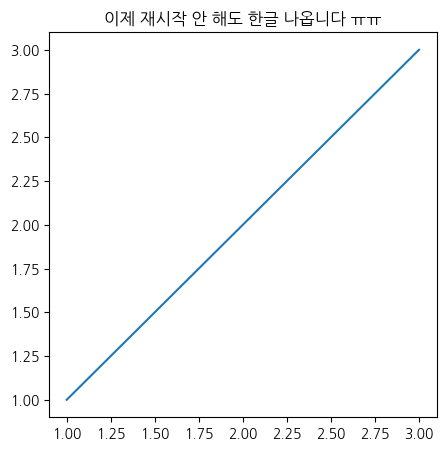

In [115]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# 1. 나눔고딕 폰트 파일만 다운로드 (설치 아님, 다운로드임)
!wget 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'

# 2. 다운로드 받은 폰트를 Matplotlib에 강제 추가
fm.fontManager.addfont('NanumGothic-Regular.ttf')

# 3. 폰트 설정 적용
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# --- 테스트 ---
plt.figure(figsize=(5,5))
plt.plot([1, 2, 3], [1, 2, 3])
plt.title('이제 재시작 안 해도 한글 나옵니다 ㅠㅠ')
plt.show()